# Virtual Internship Experience ID/X Partners
## Analisis dan Klasifikasi Kualitas Peminjam Dana dengan Metode Random Forest
### Oleh: Habiburrohman - Matematika ITB 2021

# A. Import Library

In [1]:
# Mengimpor library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import plotly
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# B. Import Dataset

In [2]:
# Mempersiapkan dataset
loan = pd.read_csv("loan_data_2007_2014.csv", low_memory=False)
loan.head()

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade  ... total_bal_il il_util  \
0   36 months     10.65       162.87     B  ...          NaN     NaN   
1   60 months     15.27        59.83     C  ...          NaN     NaN   
2   36 months     15.96        84.33     C  ...          NaN     NaN   
3   36 months     13.49       339.31     C  ...          NaN     NaN   
4   60 months     12.69        67.79     B  ...          NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN         NaN         NaN      NaN              NaN    NaN   
1         NaN         NaN         NaN      NaN              NaN    NaN   
2         NaN         NaN         NaN      NaN              NaN    NaN   
3         NaN         NaN         NaN      NaN              NaN    NaN   
4         NaN         NaN         NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 75 columns]

In [3]:
loan.shape, loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

((466285, 75), None)

In [4]:
i = 0
for col in loan.columns:
    print(loan[col].dtype)

int64
int64
int64
int64
int64
float64
object
float64
float64
object
object
object
object
object
float64
object
object
object
object
object
object
object
object
object
object
float64
float64
object
float64
float64
float64
float64
float64
int64
float64
float64
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
float64
object
object
float64
float64
int64
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


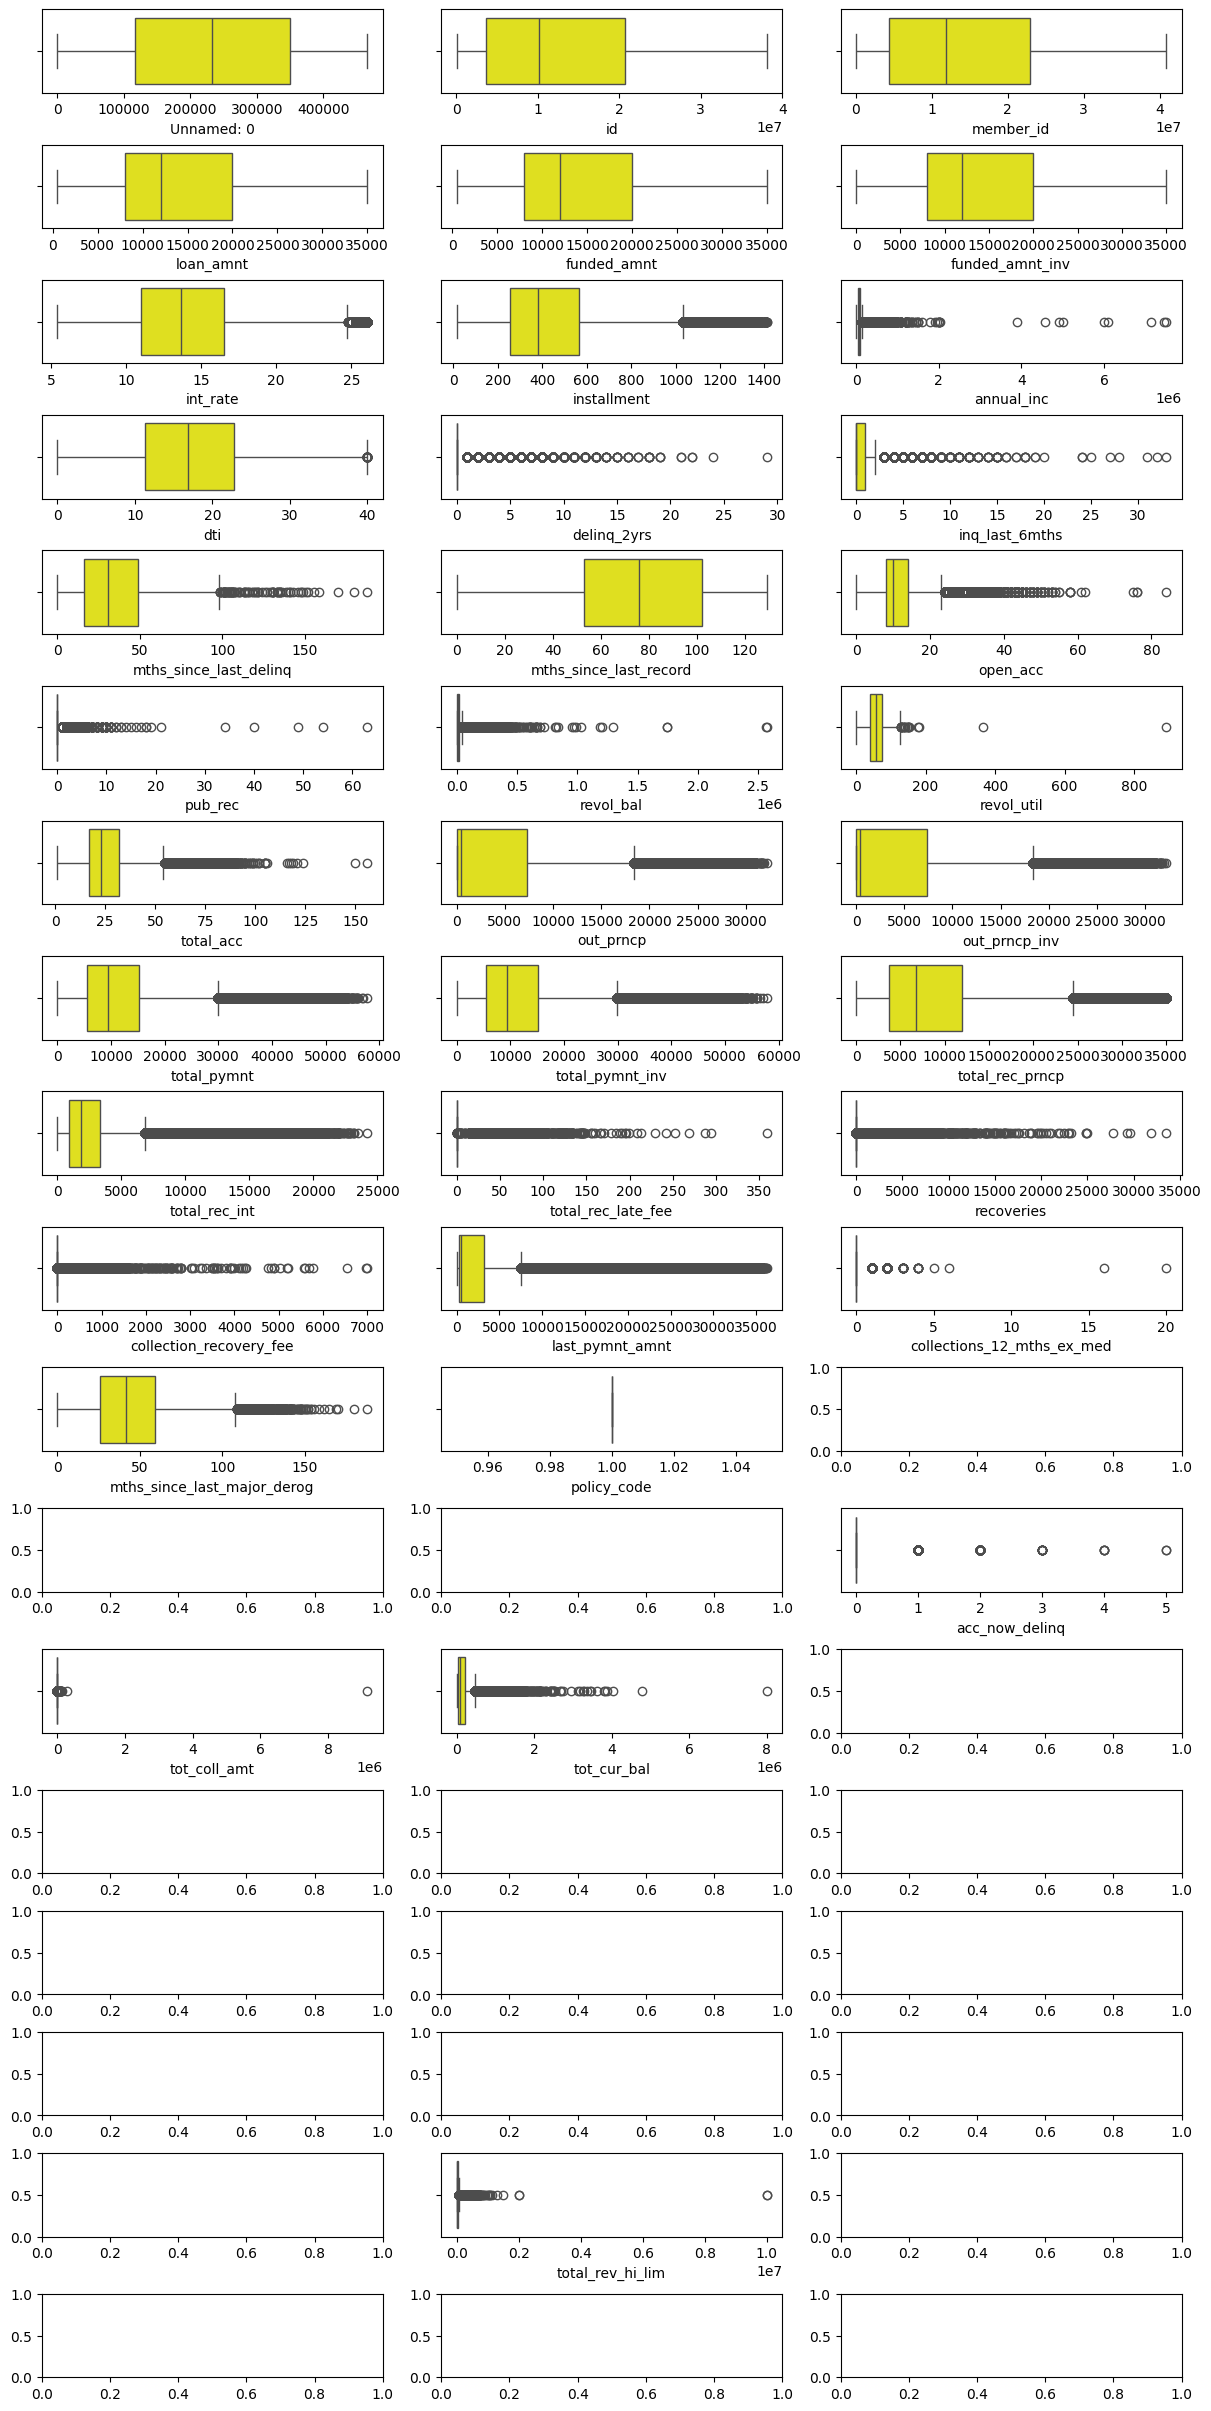

In [5]:
# Visualisasi boxplot setiap fitur numerik
numeric_cols = [col for col in loan.columns if loan[col].dtype in ["int64", "float64"]]
fig, axes = plt.subplots(18, 3, figsize=(12, 24), constrained_layout=True)
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    if not pd.isna(loan[col]).all() == True:
        sns.boxplot(x=loan[col], ax=axes[i], color="yellow")
plt.show()

In [6]:
# Persentase missing values fitur numerik
missing_percentage = loan.isnull().sum() * 100 / len(loan)
missing_values_df = pd.DataFrame({"Feature": loan.columns, "Missing Values (%)": missing_percentage.values})
missing_values_df.sort_values("Missing Values (%)", ascending=False, inplace=True, ignore_index=True)
missing_values_df[missing_values_df["Missing Values (%)"] > 10]

Feature  Missing Values (%)
0                    max_bal_bc          100.000000
1                   open_rv_24m          100.000000
2                        inq_fi          100.000000
3                   open_rv_12m          100.000000
4                       il_util          100.000000
5            mths_since_rcnt_il          100.000000
6                  total_bal_il          100.000000
7                   open_il_24m          100.000000
8                   open_il_12m          100.000000
9                    open_il_6m          100.000000
10                  open_acc_6m          100.000000
11                    dti_joint          100.000000
12             annual_inc_joint          100.000000
13    verification_status_joint          100.000000
14                     all_util          100.000000
15                 inq_last_12m          100.000000
16                  total_cu_tl          100.000000
17       mths_since_last_record           86.566585
18  mths_since_last_major_derog           78.773926
19                         desc           72.981975
20       mths_since_last_delinq           53.690554
21                 next_pymnt_d           48.728567
22                 tot_coll_amt           15.071469
23             total_rev_hi_lim           15.071469
24                  tot_cur_bal           15.071469

In [7]:
# Cek data duplikat
loan.drop_duplicates()
loan.drop_duplicates(subset=["id"])
loan.drop_duplicates(subset=["member_id"])
loan.shape

(466285, 75)

In [8]:
loan["Unnamed: 0"].unique()

array([     0,      1,      2, ..., 466282, 466283, 466284],
      shape=(466285,))

In [9]:
loan["id"].unique()

array([1077501, 1077430, 1077175, ..., 9584776, 9604874, 9199665],
      shape=(466285,))

In [10]:
loan["member_id"].unique()

array([ 1296599,  1314167,  1313524, ..., 11436914, 11457002, 11061576],
      shape=(466285,))

In [11]:
loan["zip_code"].value_counts()

zip_code
945xx    5304
112xx    5102
750xx    5013
606xx    4696
100xx    4391
         ... 
510xx       1
516xx       1
587xx       1
511xx       1
901xx       1
Name: count, Length: 888, dtype: int64

In [12]:
loan["policy_code"].value_counts()

policy_code
1    466285
Name: count, dtype: int64

In [13]:
loan["application_type"].value_counts()

application_type
INDIVIDUAL    466285
Name: count, dtype: int64

In [14]:
loan["pymnt_plan"].value_counts()

pymnt_plan
n    466276
y         9
Name: count, dtype: int64

In [15]:
loan["emp_title"].value_counts()

emp_title
Teacher                     5399
Manager                     4438
Registered Nurse            2316
RN                          2204
Supervisor                  1967
                            ... 
bpd/gms coordinator            1
Mathematics Dept. Chair        1
relief captain                 1
Maintenance Supervisor I       1
Driver/Shift Manager           1
Name: count, Length: 205475, dtype: int64

In [16]:
loan["title"].value_counts()

title
Debt consolidation         164075
Credit card refinancing     62275
Debt Consolidation          15760
Home improvement            14849
Other                       12713
                            ...  
Financially Fit                 1
Catch me up again               1
LoanGetter                      1
Consolidation 01                1
Sugar                           1
Name: count, Length: 63098, dtype: int64

In [17]:
loan[loan["delinq_2yrs"].isnull()][
    ["delinq_2yrs", "open_acc", 
    "pub_rec", "earliest_cr_line", 
    "inq_last_6mths", "acc_now_delinq"]
    ].isnull().sum()

delinq_2yrs         29
open_acc            29
pub_rec             29
earliest_cr_line    29
inq_last_6mths      29
acc_now_delinq      29
dtype: int64

# C. Data Cleaning 1

In [18]:
def cleaning(df):
    df = df.applymap(lambda x: x.lower() if isinstance(x,str) else x)
    
    for col in df.columns:
        if df[col].isnull().sum() > 0.1*len(df):
            df.drop(col, axis=1, inplace=True)
    
    df.drop_duplicates()
    df.drop_duplicates(subset=["id"])
    df.drop_duplicates(subset=["member_id"])
    
    df.drop(["Unnamed: 0", "id", "member_id", "url", "zip_code", "policy_code", 
             "application_type", "pymnt_plan", "emp_title", "title"], axis=1, inplace=True)
  
    df.dropna(subset=["delinq_2yrs", "open_acc","pub_rec", 
                    "earliest_cr_line","inq_last_6mths", 
                    "acc_now_delinq"], how="all", inplace=True)

    # Menghapus outlier per fitur numerik jika jumlahnya tidak melebihi 3% dari jumlah keseluruhan data
    # Jika jumlahnya melebihi 3%, maka diasumsikan outlier tersebut natural (alami), jadi tidak perlu dihapus
    
    for col in df.columns:
        if df[col].dtype == "int64" or df[col].dtype == "float64":
            Q1, Q3 = df[col].describe()["25%"], df[col].describe()["75%"]
            IQR = Q3 - Q1
            LB, UB = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            outlier_count = len(df) - len(df[(df[col] >= LB) & (df[col] <= UB)])
            if outlier_count <= 0.03*len(df): 
                df = df[(df[col] >= LB) & (df[col] <= UB)]
            else: 
                pass
    
    return df

In [19]:
loan = cleaning(loan)
loan.shape, loan.info()

C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\1582055617.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x,str) else x)


<class 'pandas.core.frame.DataFrame'>
Index: 418722 entries, 0 to 466284
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   418722 non-null  int64  
 1   funded_amnt                 418722 non-null  int64  
 2   funded_amnt_inv             418722 non-null  float64
 3   term                        418722 non-null  object 
 4   int_rate                    418722 non-null  float64
 5   installment                 418722 non-null  float64
 6   grade                       418722 non-null  object 
 7   sub_grade                   418722 non-null  object 
 8   emp_length                  399394 non-null  object 
 9   home_ownership              418722 non-null  object 
 10  annual_inc                  418722 non-null  float64
 11  verification_status         418722 non-null  object 
 12  issue_d                     418722 non-null  object 
 13  loan_status        

((418722, 40), None)

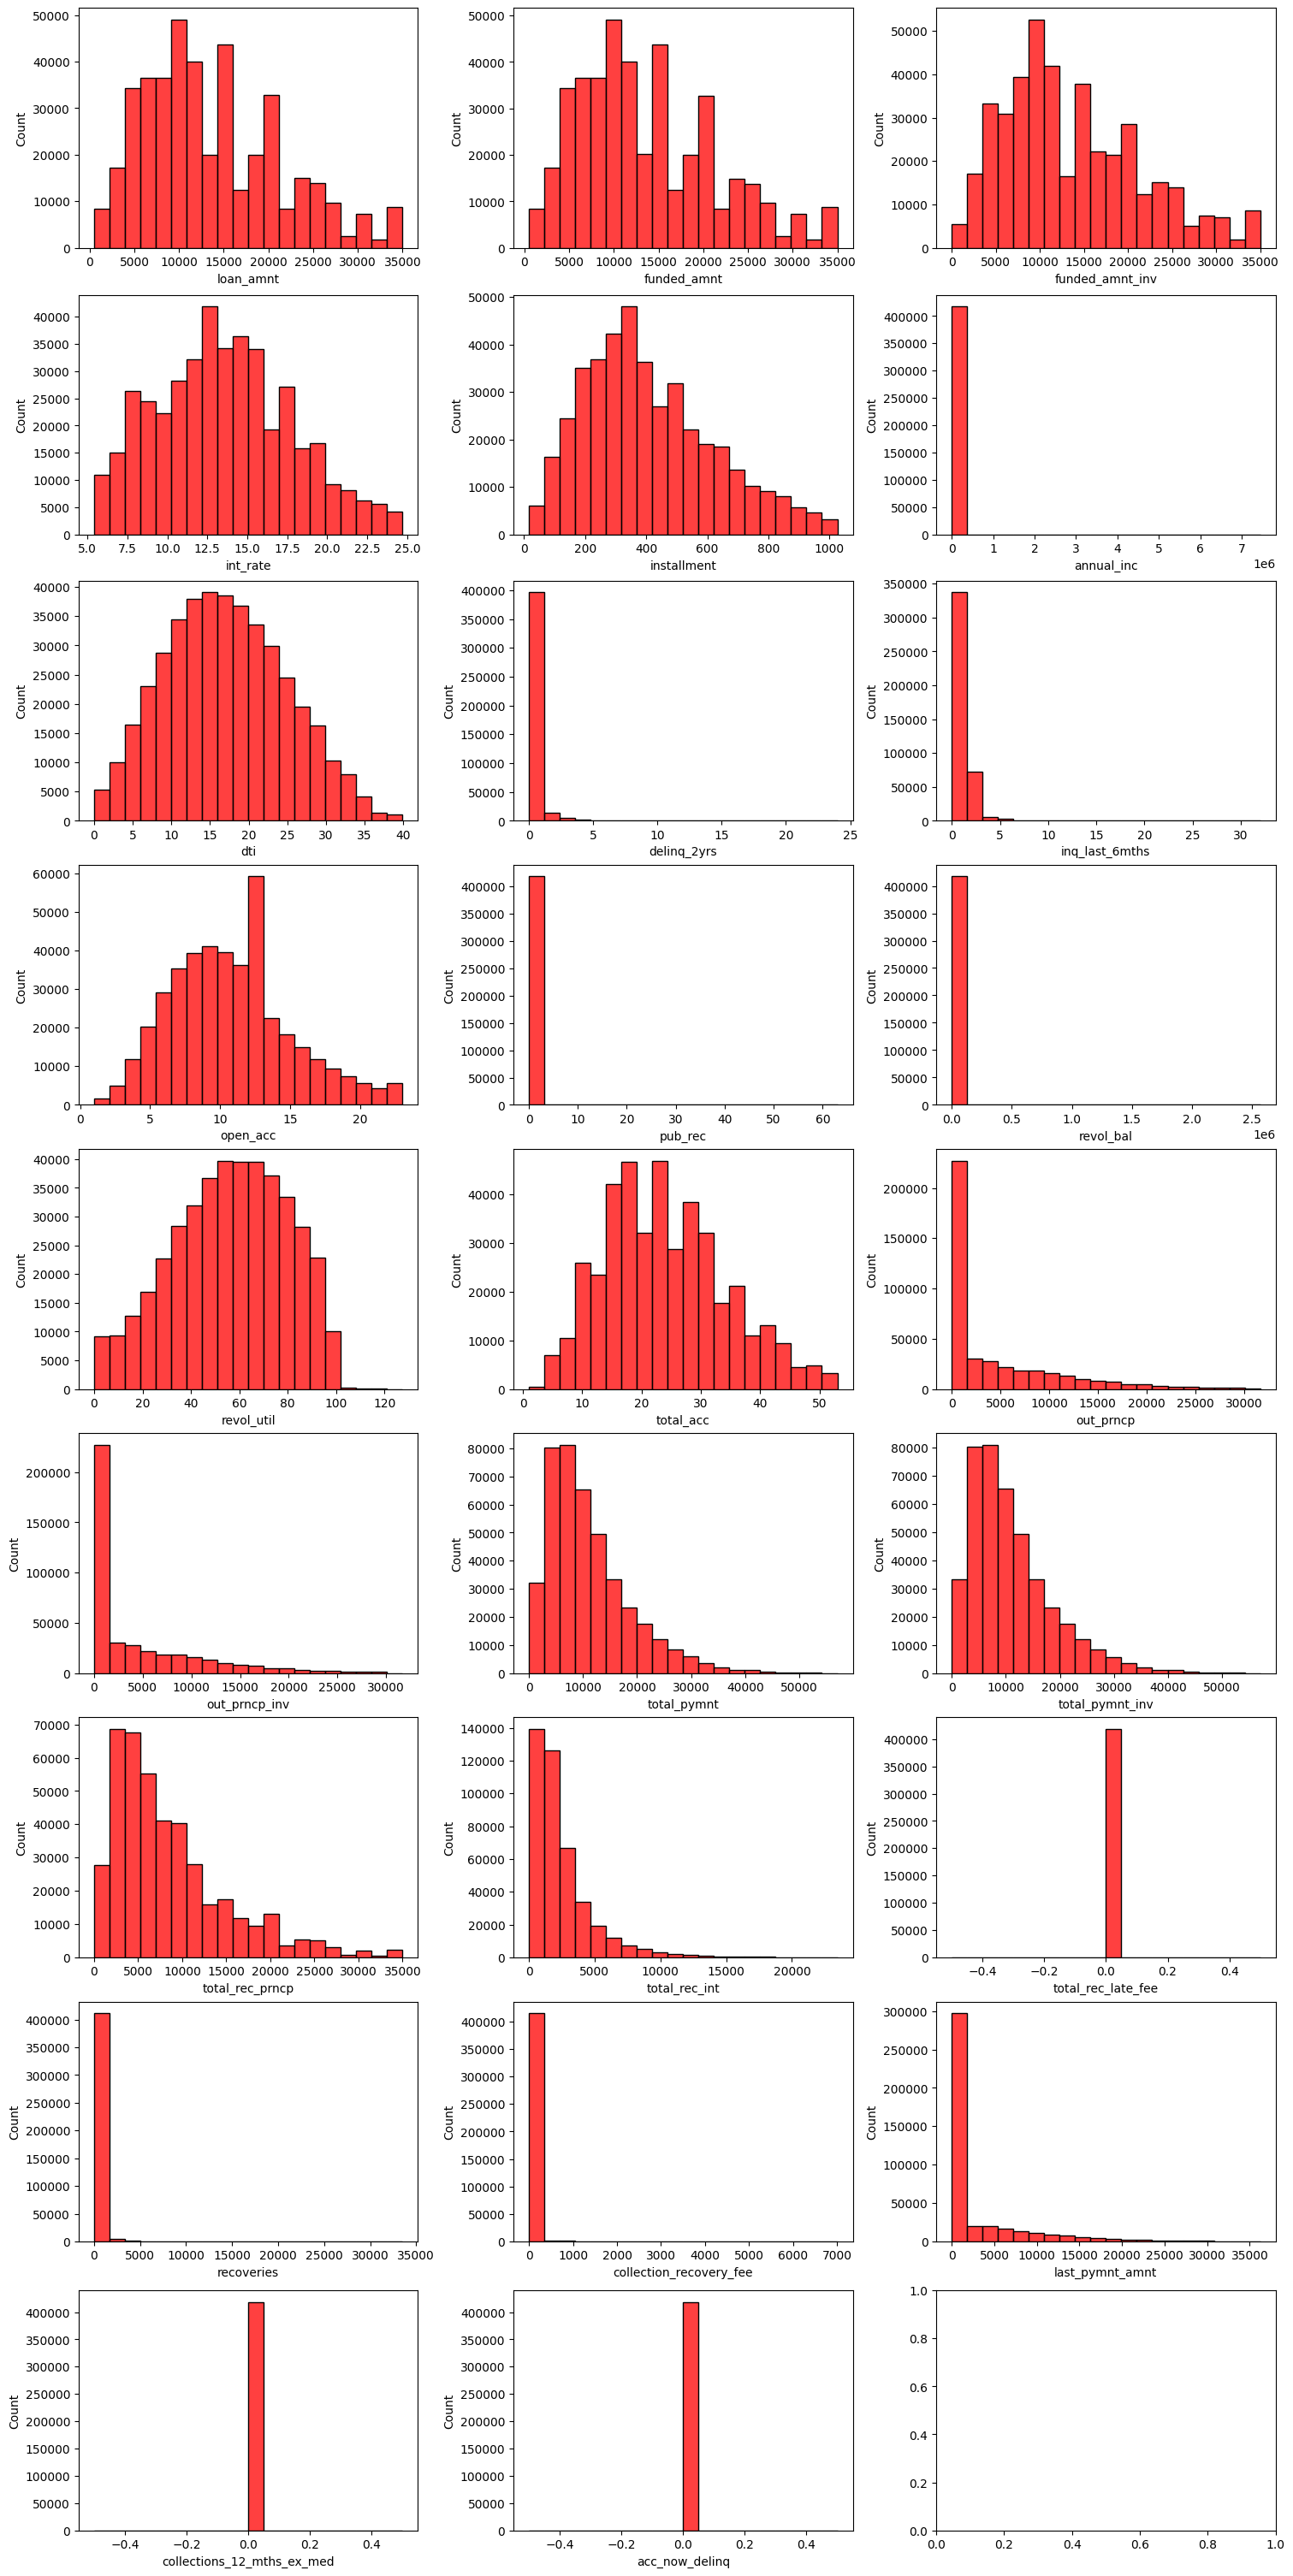

In [20]:
# for col in loan.columns:
# sns.histplot(x=loan["loan_amnt"], color="green", kde=True)
fig, axes = plt.subplots(9, 3, figsize=(15, 30), constrained_layout=True)
i, j = 0, 0
for col in loan.columns:
    if loan[col].dtype == "int64" or loan[col].dtype == "float64":   
        if j % 3 == 0 and j != 0:
            i += 1
            j %= 3
        sns.histplot(x=loan[col], bins=20, color="red", ax=axes[i][j])
        j += 1

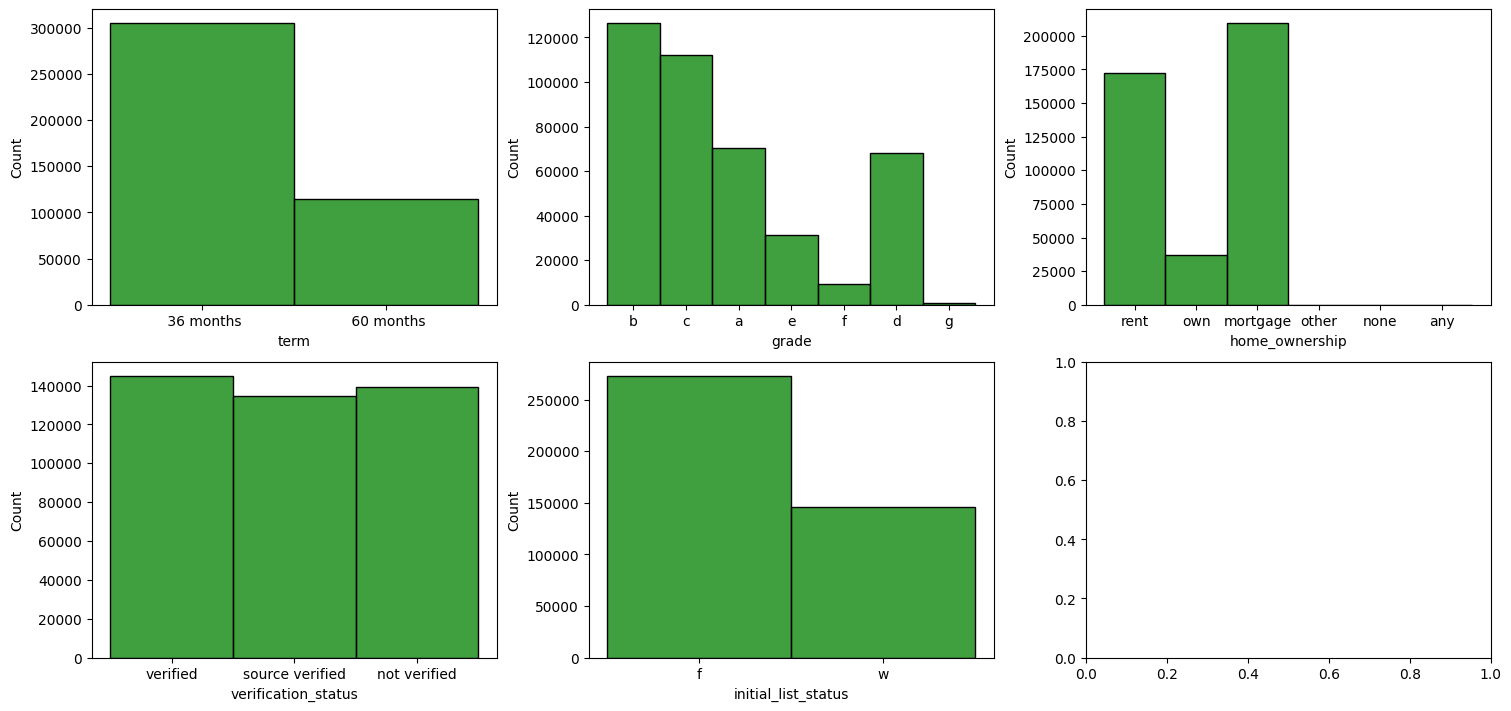

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7), constrained_layout=True)
columns = ["term", "grade", "home_ownership", "verification_status", "initial_list_status"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sns.histplot(x=loan[col], color="green", ax=axes[i][j])
    j += 1

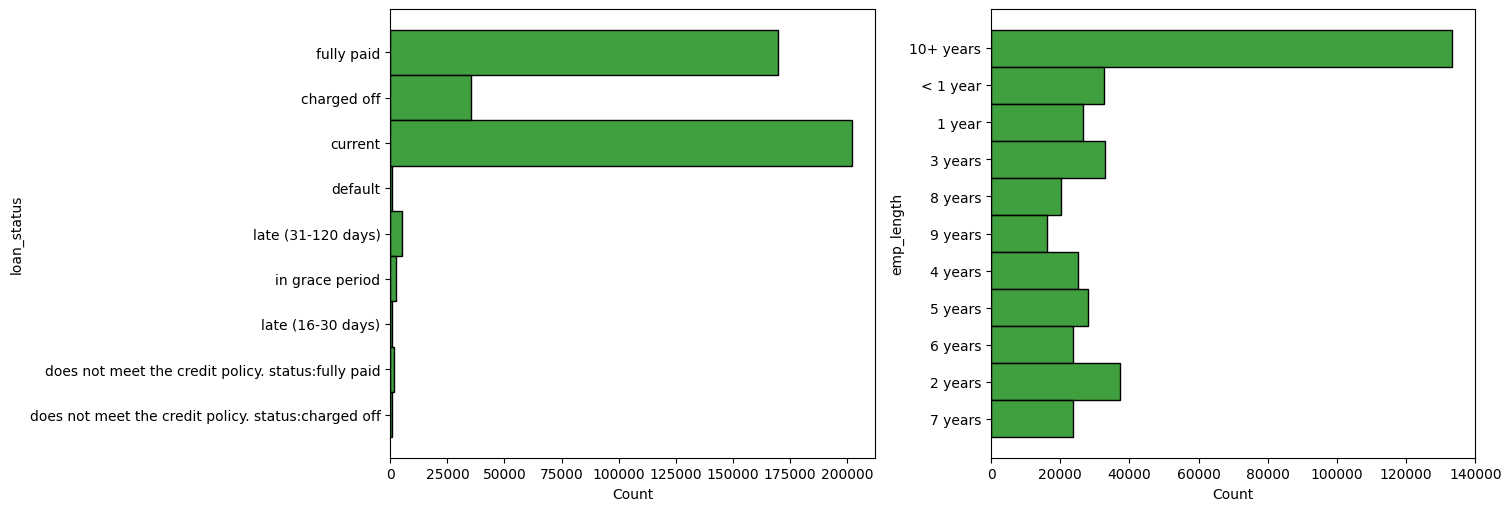

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
columns = ["loan_status", "emp_length"]
i = 0
for col in columns:
    sns.histplot(y=loan[col], color="green", ax=axes[i])
    i += 1

<Axes: xlabel='sub_grade', ylabel='Count'>

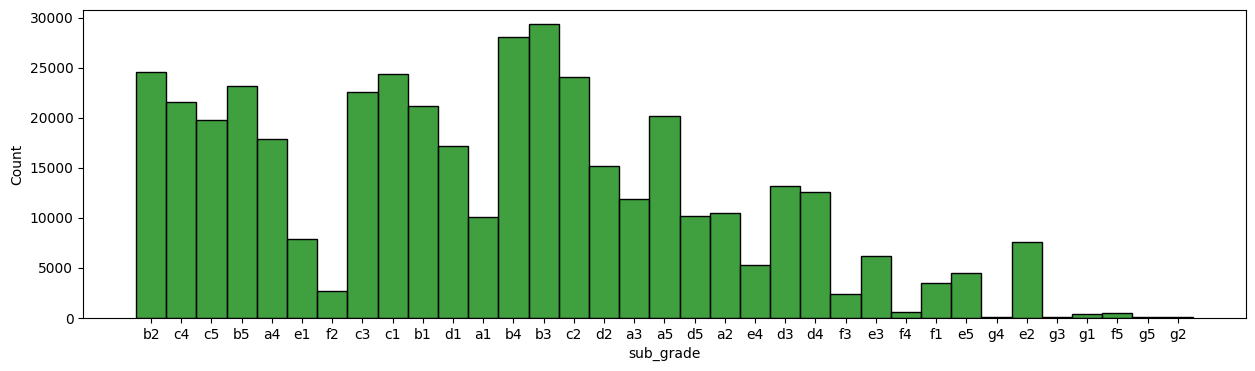

In [23]:
plt.figure(figsize=(15, 4))
sns.histplot(x=loan["sub_grade"], color="green")

<Axes: >

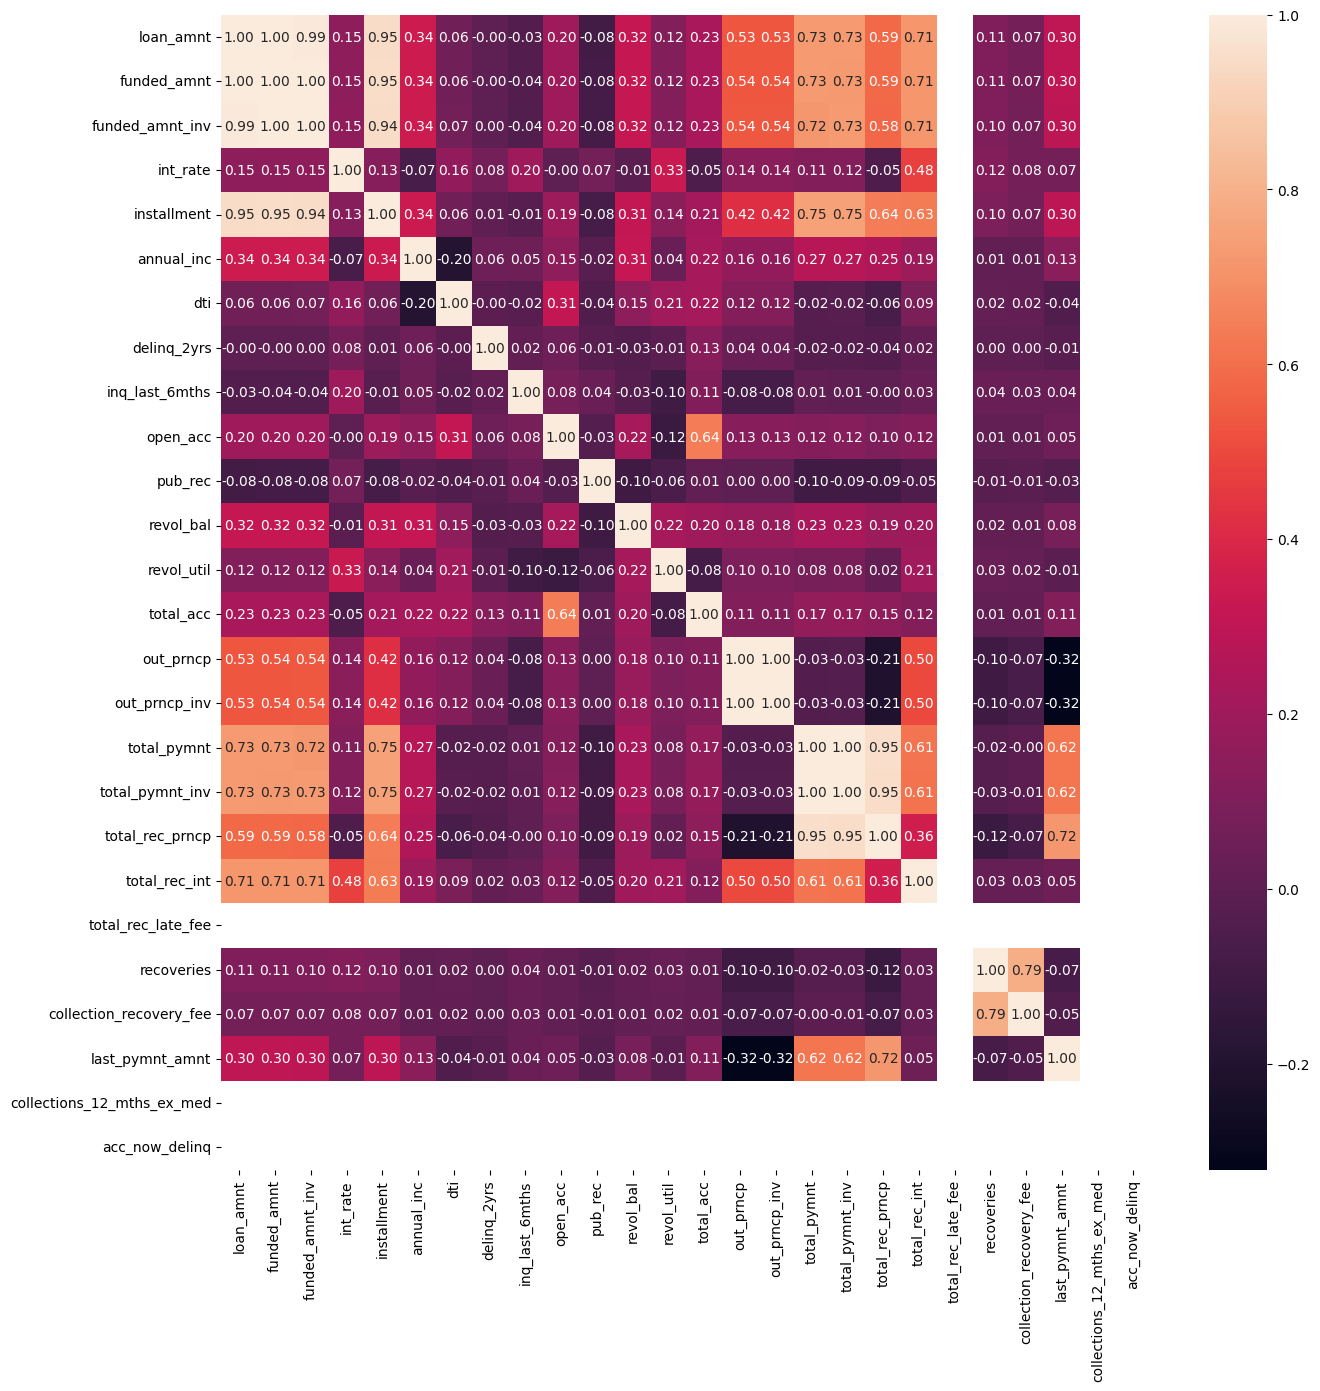

In [24]:
plt.figure(figsize=(15, 15))
sns.heatmap(loan.corr(numeric_only=True), annot=True, fmt=".2f")

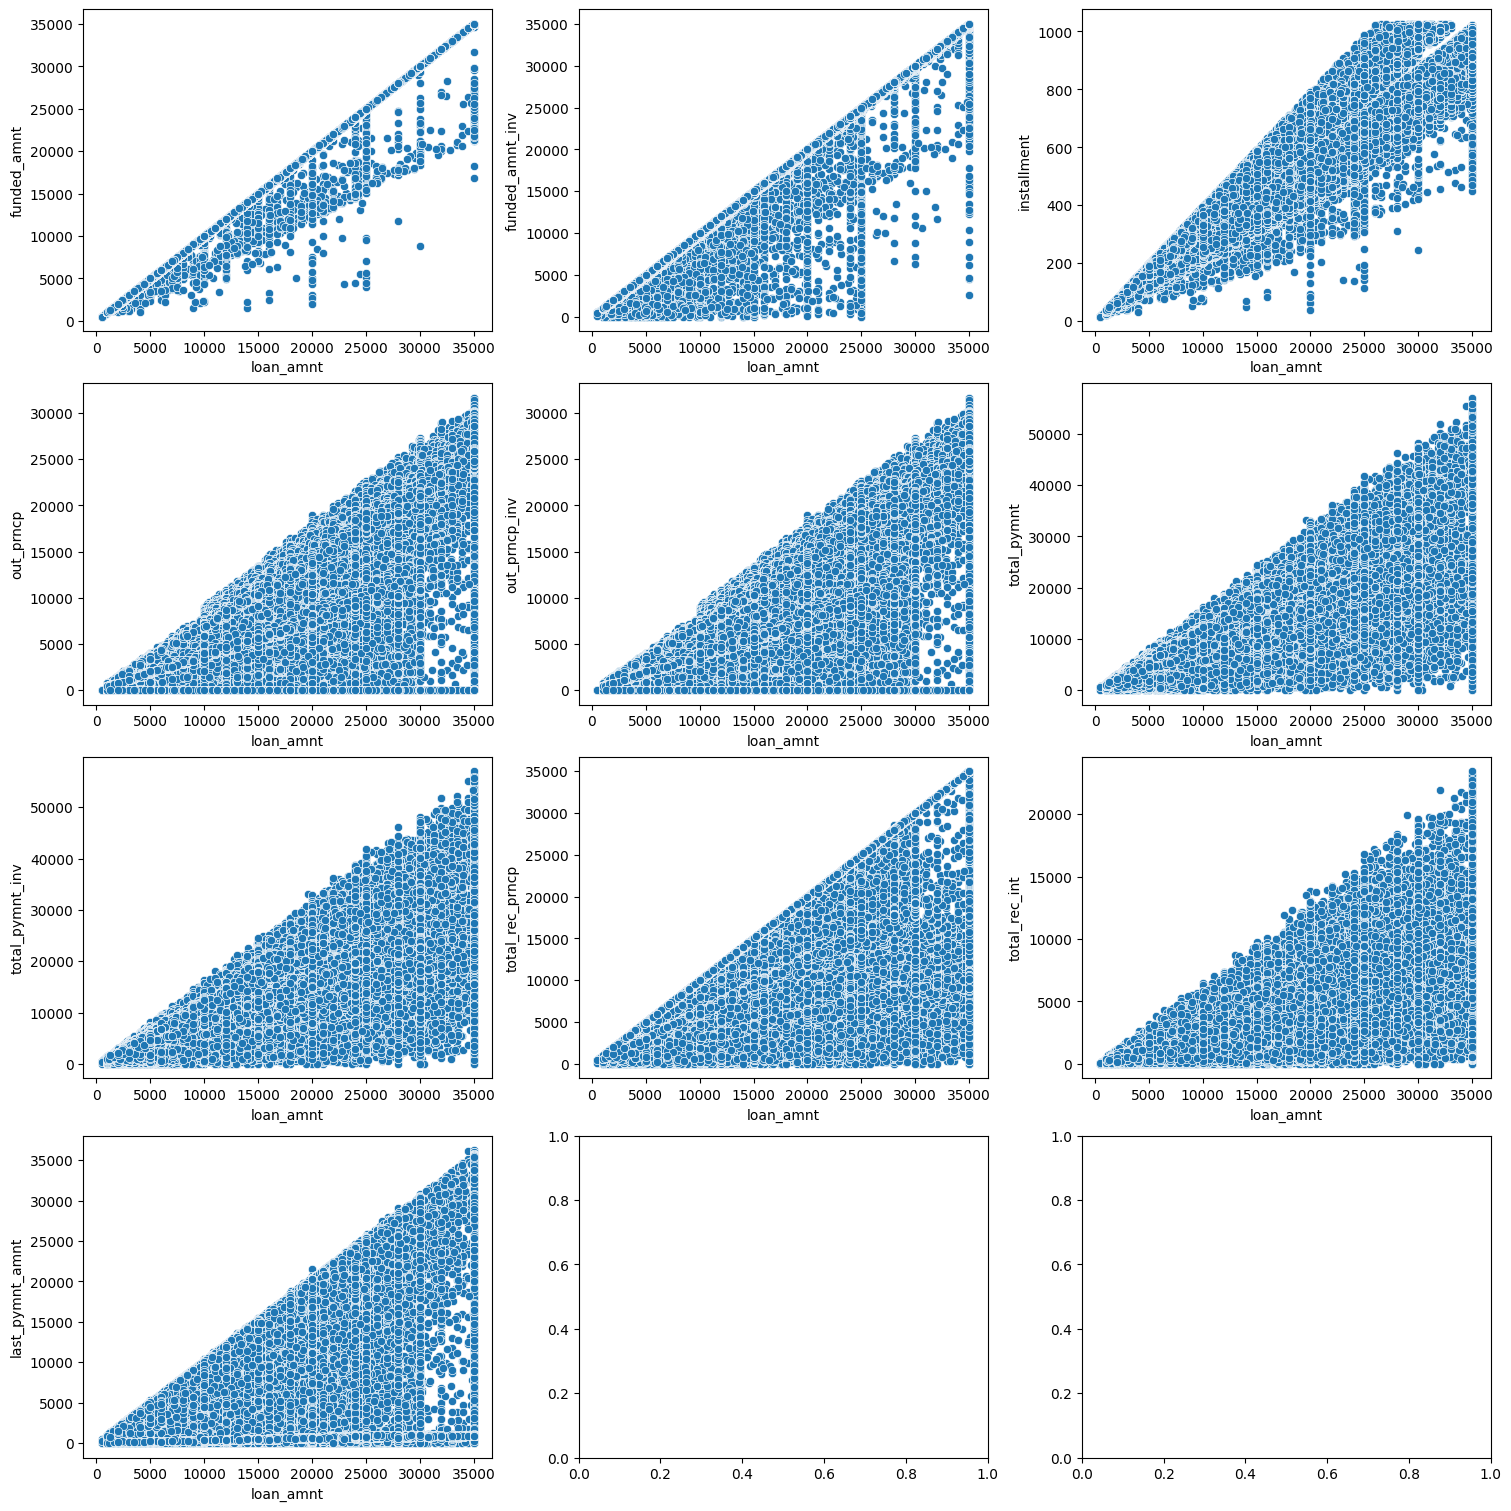

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15), constrained_layout=True)
columns = ["funded_amnt", "funded_amnt_inv", "installment", "out_prncp", "out_prncp_inv", "total_pymnt", 
           "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "last_pymnt_amnt"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sns.scatterplot(data=loan, x="loan_amnt", y=col, ax=axes[i][j])
    j += 1

<Axes: xlabel='int_rate', ylabel='total_rec_int'>

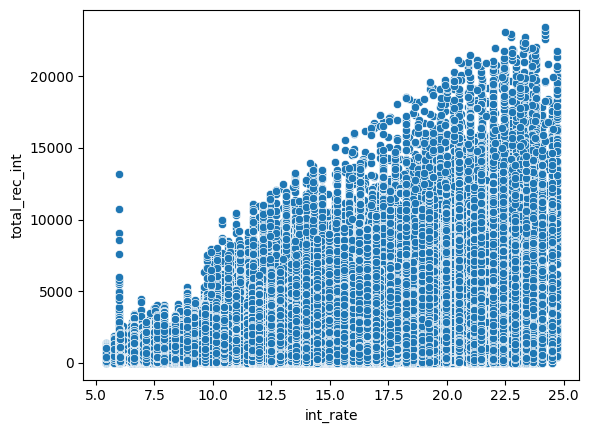

In [26]:
sns.scatterplot(data=loan, x="int_rate", y="total_rec_int", )

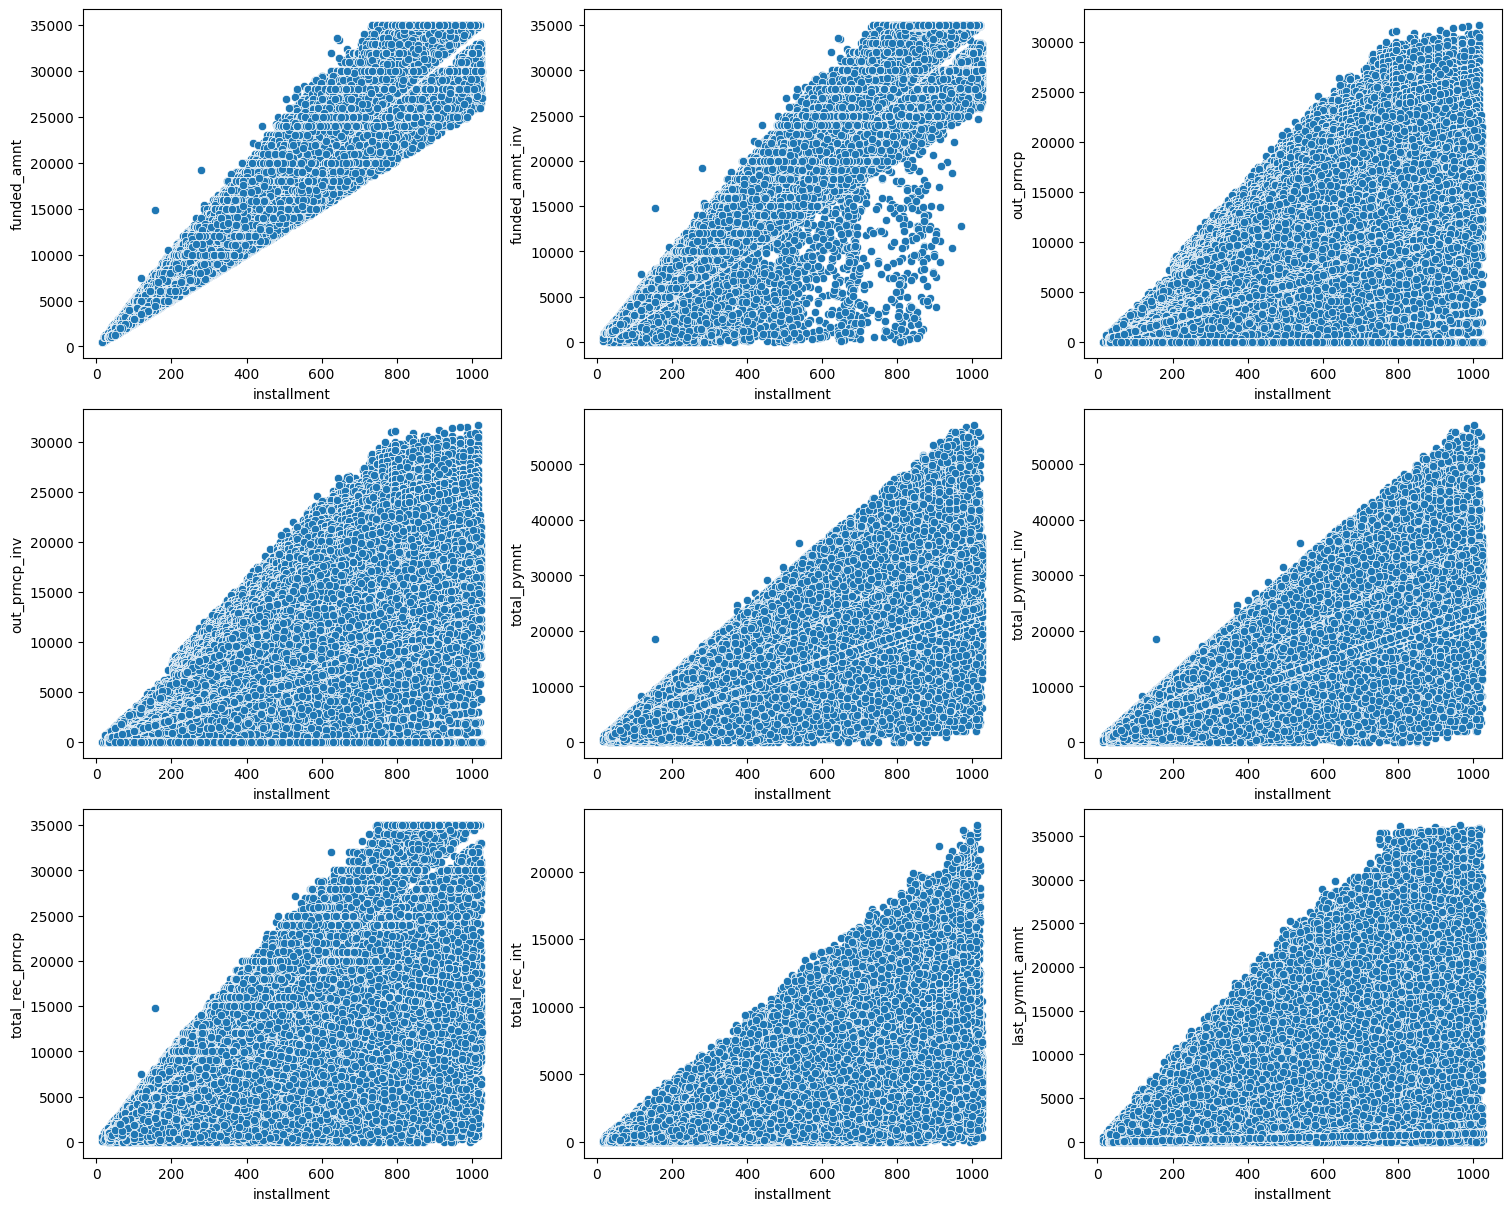

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), constrained_layout=True)
columns = ["funded_amnt", "funded_amnt_inv", "out_prncp", "out_prncp_inv", "total_pymnt", 
           "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "last_pymnt_amnt"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sns.scatterplot(data=loan, x="installment", y=col, ax=axes[i][j])
    j += 1

<Axes: xlabel='open_acc', ylabel='total_acc'>

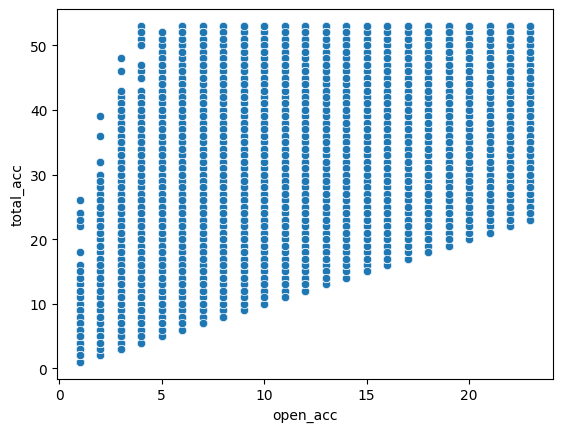

In [28]:
sns.scatterplot(data=loan, x="open_acc", y="total_acc")

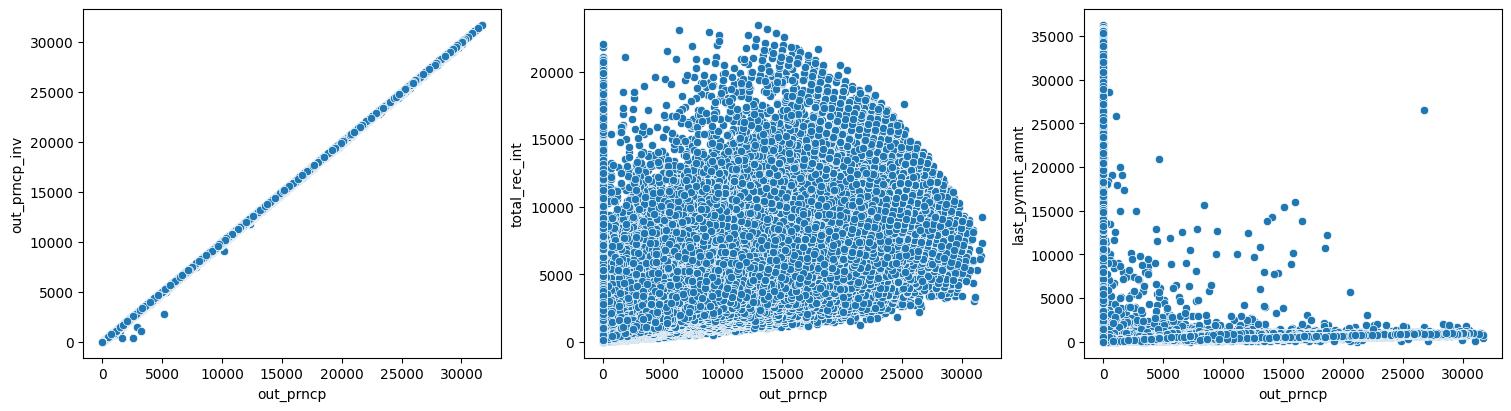

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
columns = ["out_prncp_inv", "total_rec_int", "last_pymnt_amnt"]
i = 0
for col in columns:
    sns.scatterplot(data=loan, x="out_prncp", y=col, ax=axes[i])
    i += 1

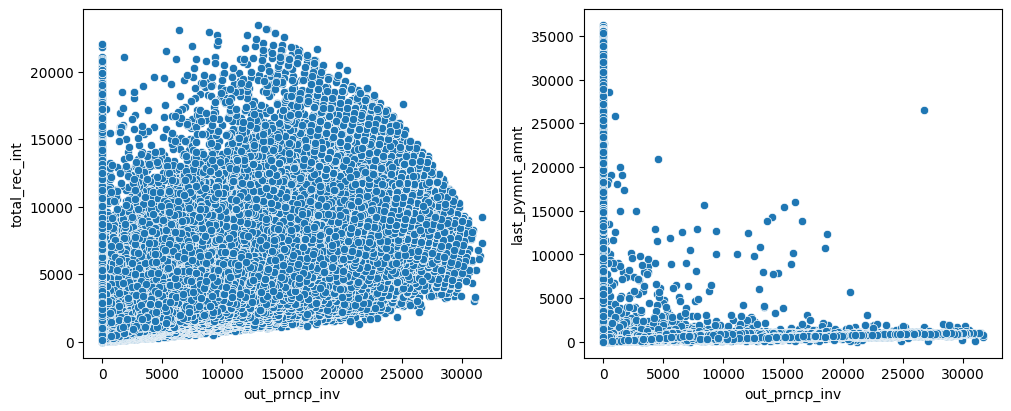

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
columns = ["total_rec_int", "last_pymnt_amnt"]
i = 0
for col in columns:
    sns.scatterplot(data=loan, x="out_prncp_inv", y=col, ax=axes[i])
    i += 1

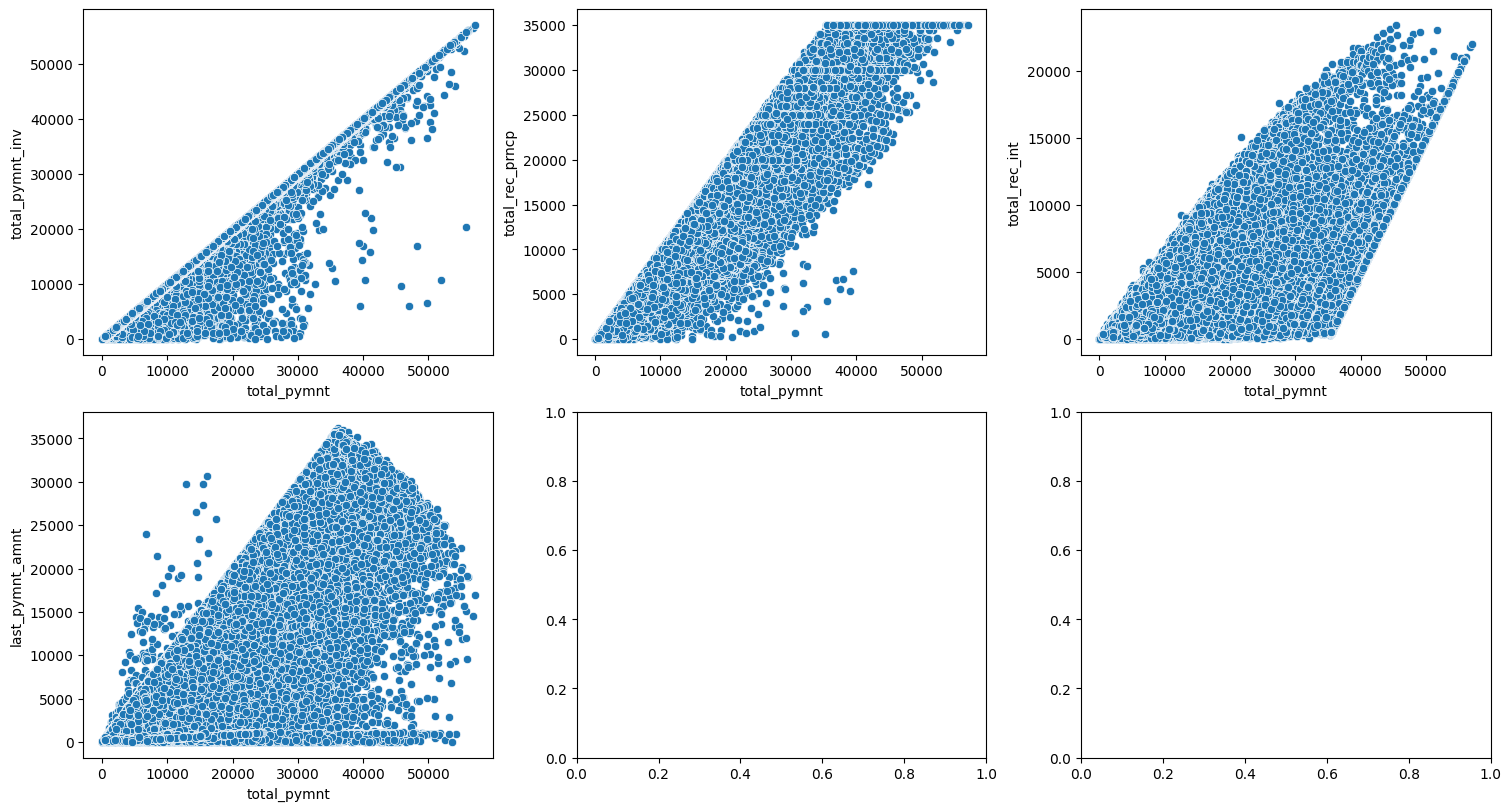

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)
columns = ["total_pymnt_inv", "total_rec_prncp", "total_rec_int", "last_pymnt_amnt"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sns.scatterplot(data=loan, x="total_pymnt", y=col, ax=axes[i][j])
    j += 1

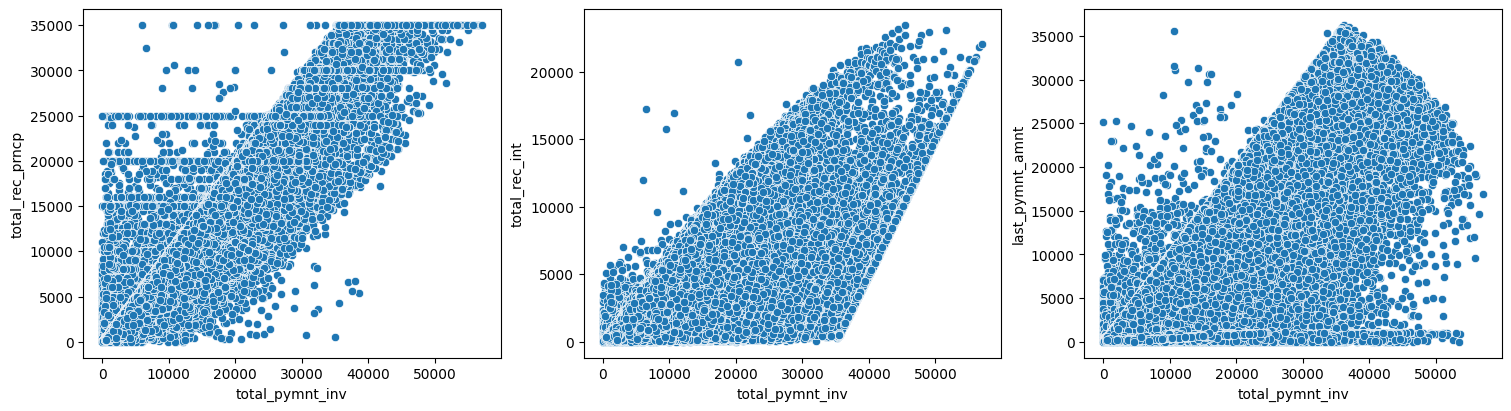

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
columns = ["total_rec_prncp", "total_rec_int", "last_pymnt_amnt"]
i = 0
for col in columns:
    sns.scatterplot(data=loan, x="total_pymnt_inv", y=col, ax=axes[i])
    i += 1

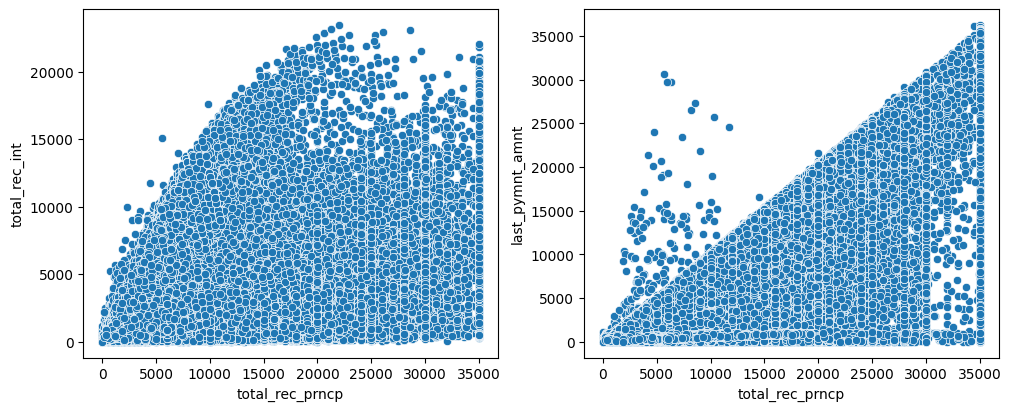

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
columns = ["total_rec_int", "last_pymnt_amnt"]
i = 0
for col in columns:
    sns.scatterplot(data=loan, x="total_rec_prncp", y=col, ax=axes[i])
    i += 1

<Axes: xlabel='total_rec_int', ylabel='last_pymnt_amnt'>

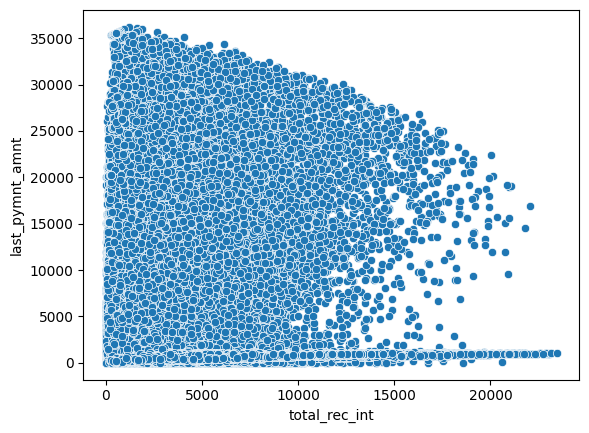

In [34]:
sns.scatterplot(data=loan, x="total_rec_int", y="last_pymnt_amnt")

<Axes: xlabel='recoveries', ylabel='collection_recovery_fee'>

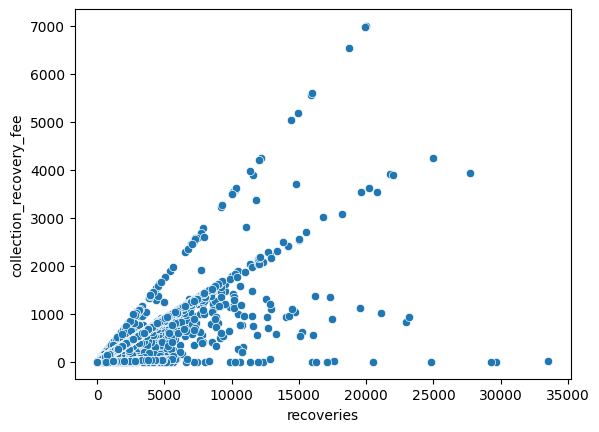

In [35]:
sns.scatterplot(data=loan, x="recoveries", y="collection_recovery_fee")

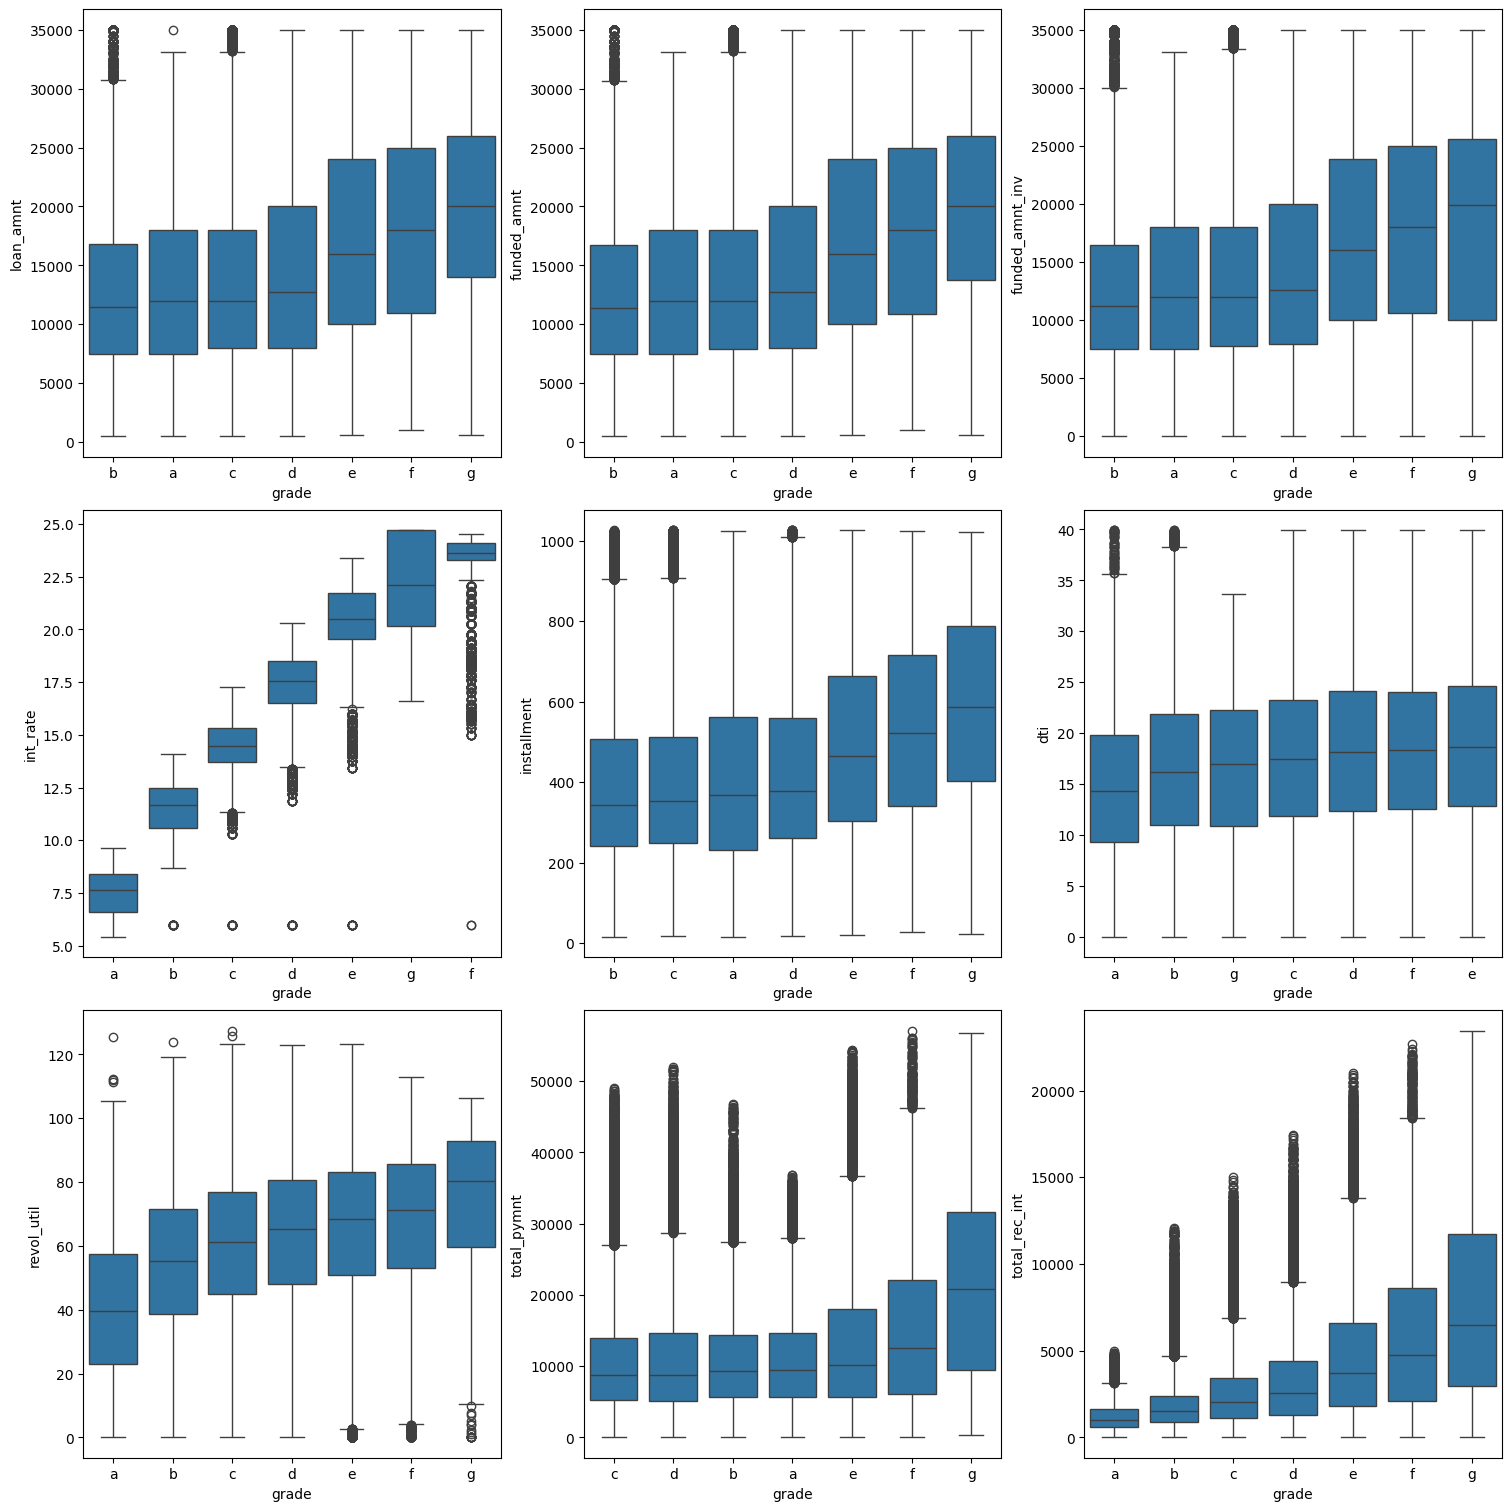

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
columns = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "dti", 
           "revol_util", "total_pymnt", "total_rec_int"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sorted_index = loan.groupby("grade")[col].median().sort_values().index
    sns.boxplot(data=loan, x="grade", y=col, order=sorted_index, ax=axes[i][j])
    j += 1

C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\686339258.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\686339258.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\686339258.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\686339258.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get

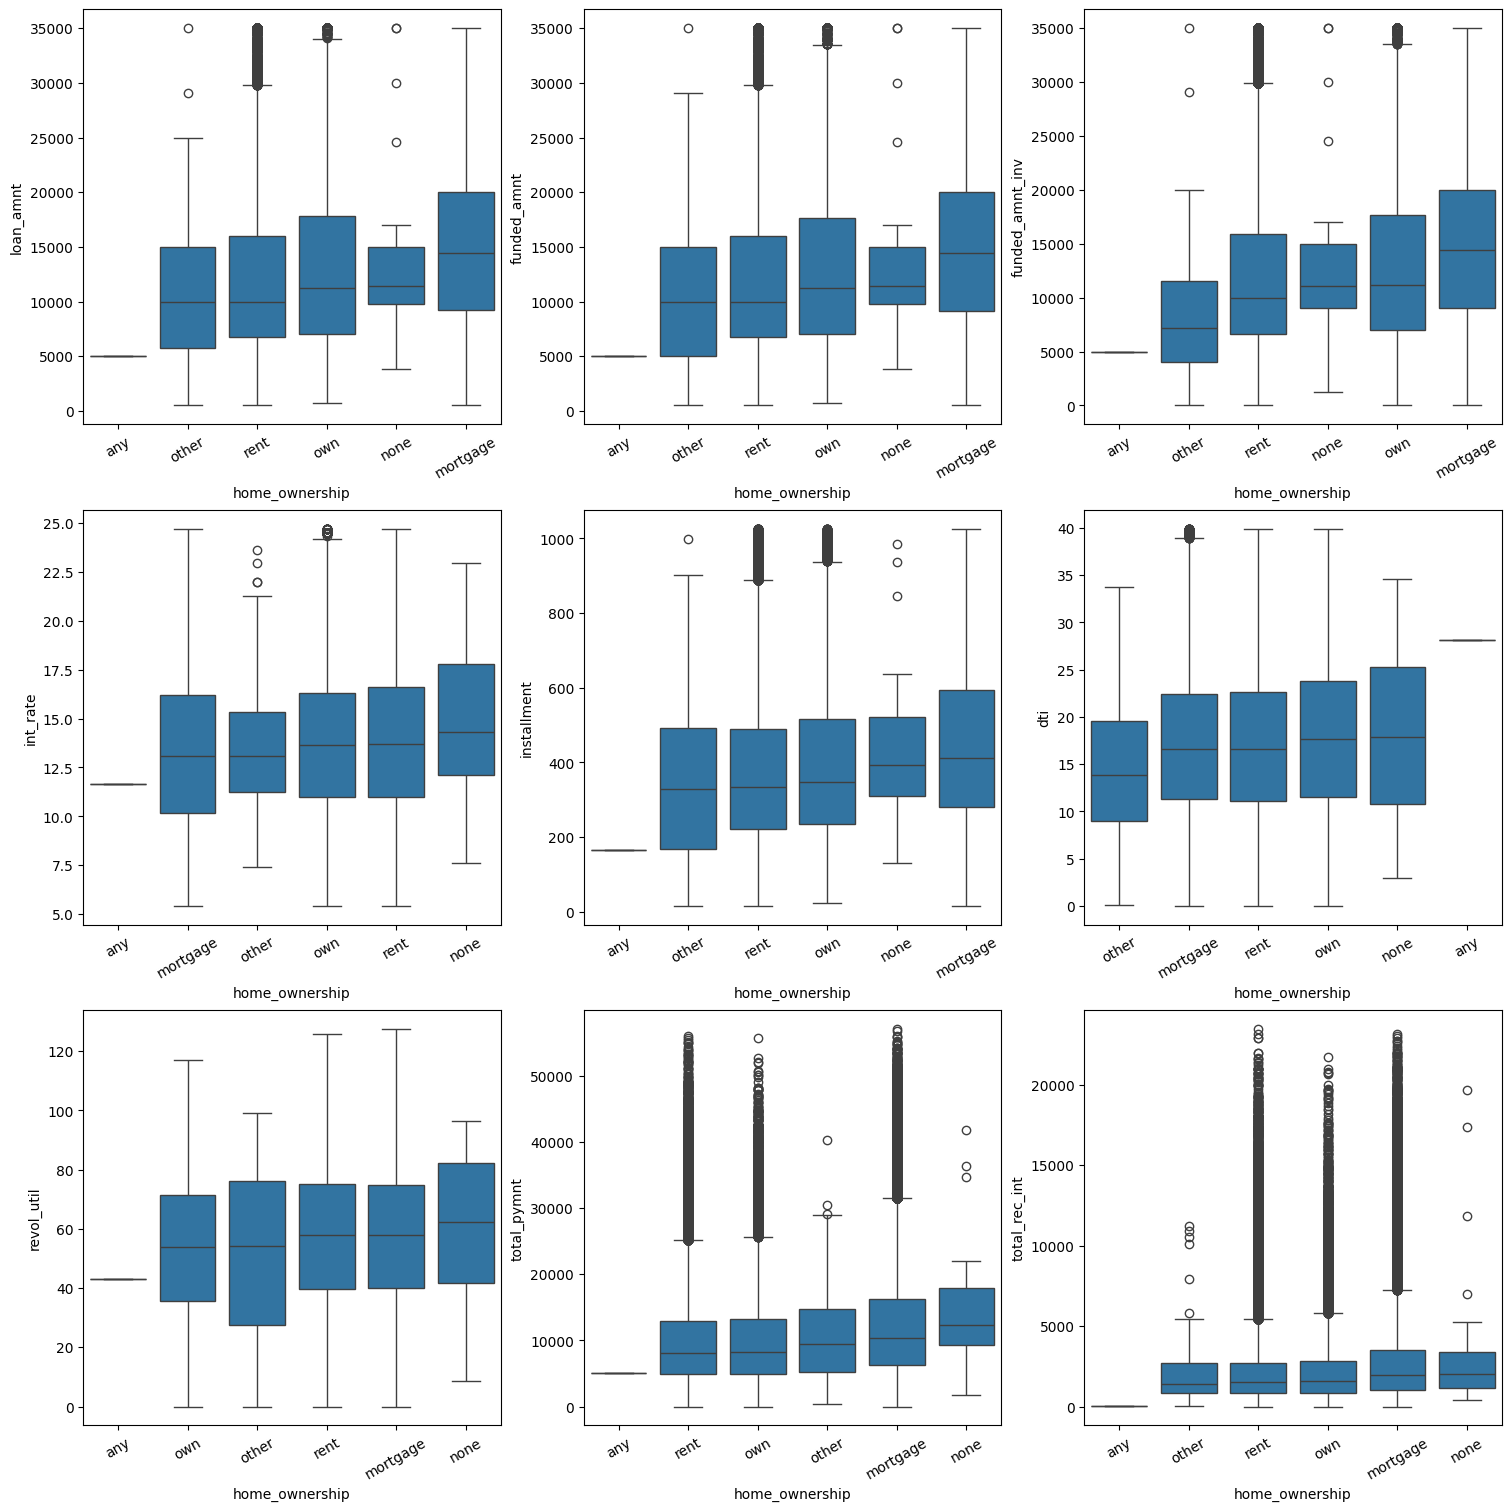

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)

columns = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "dti", 
           "revol_util", "total_pymnt", "total_rec_int"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sorted_index = loan.groupby("home_ownership")[col].median().sort_values().index
    ax = sns.boxplot(data=loan, x="home_ownership", y=col, order=sorted_index, ax=axes[i][j])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    j += 1

C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\487524669.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\487524669.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\487524669.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\487524669.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get

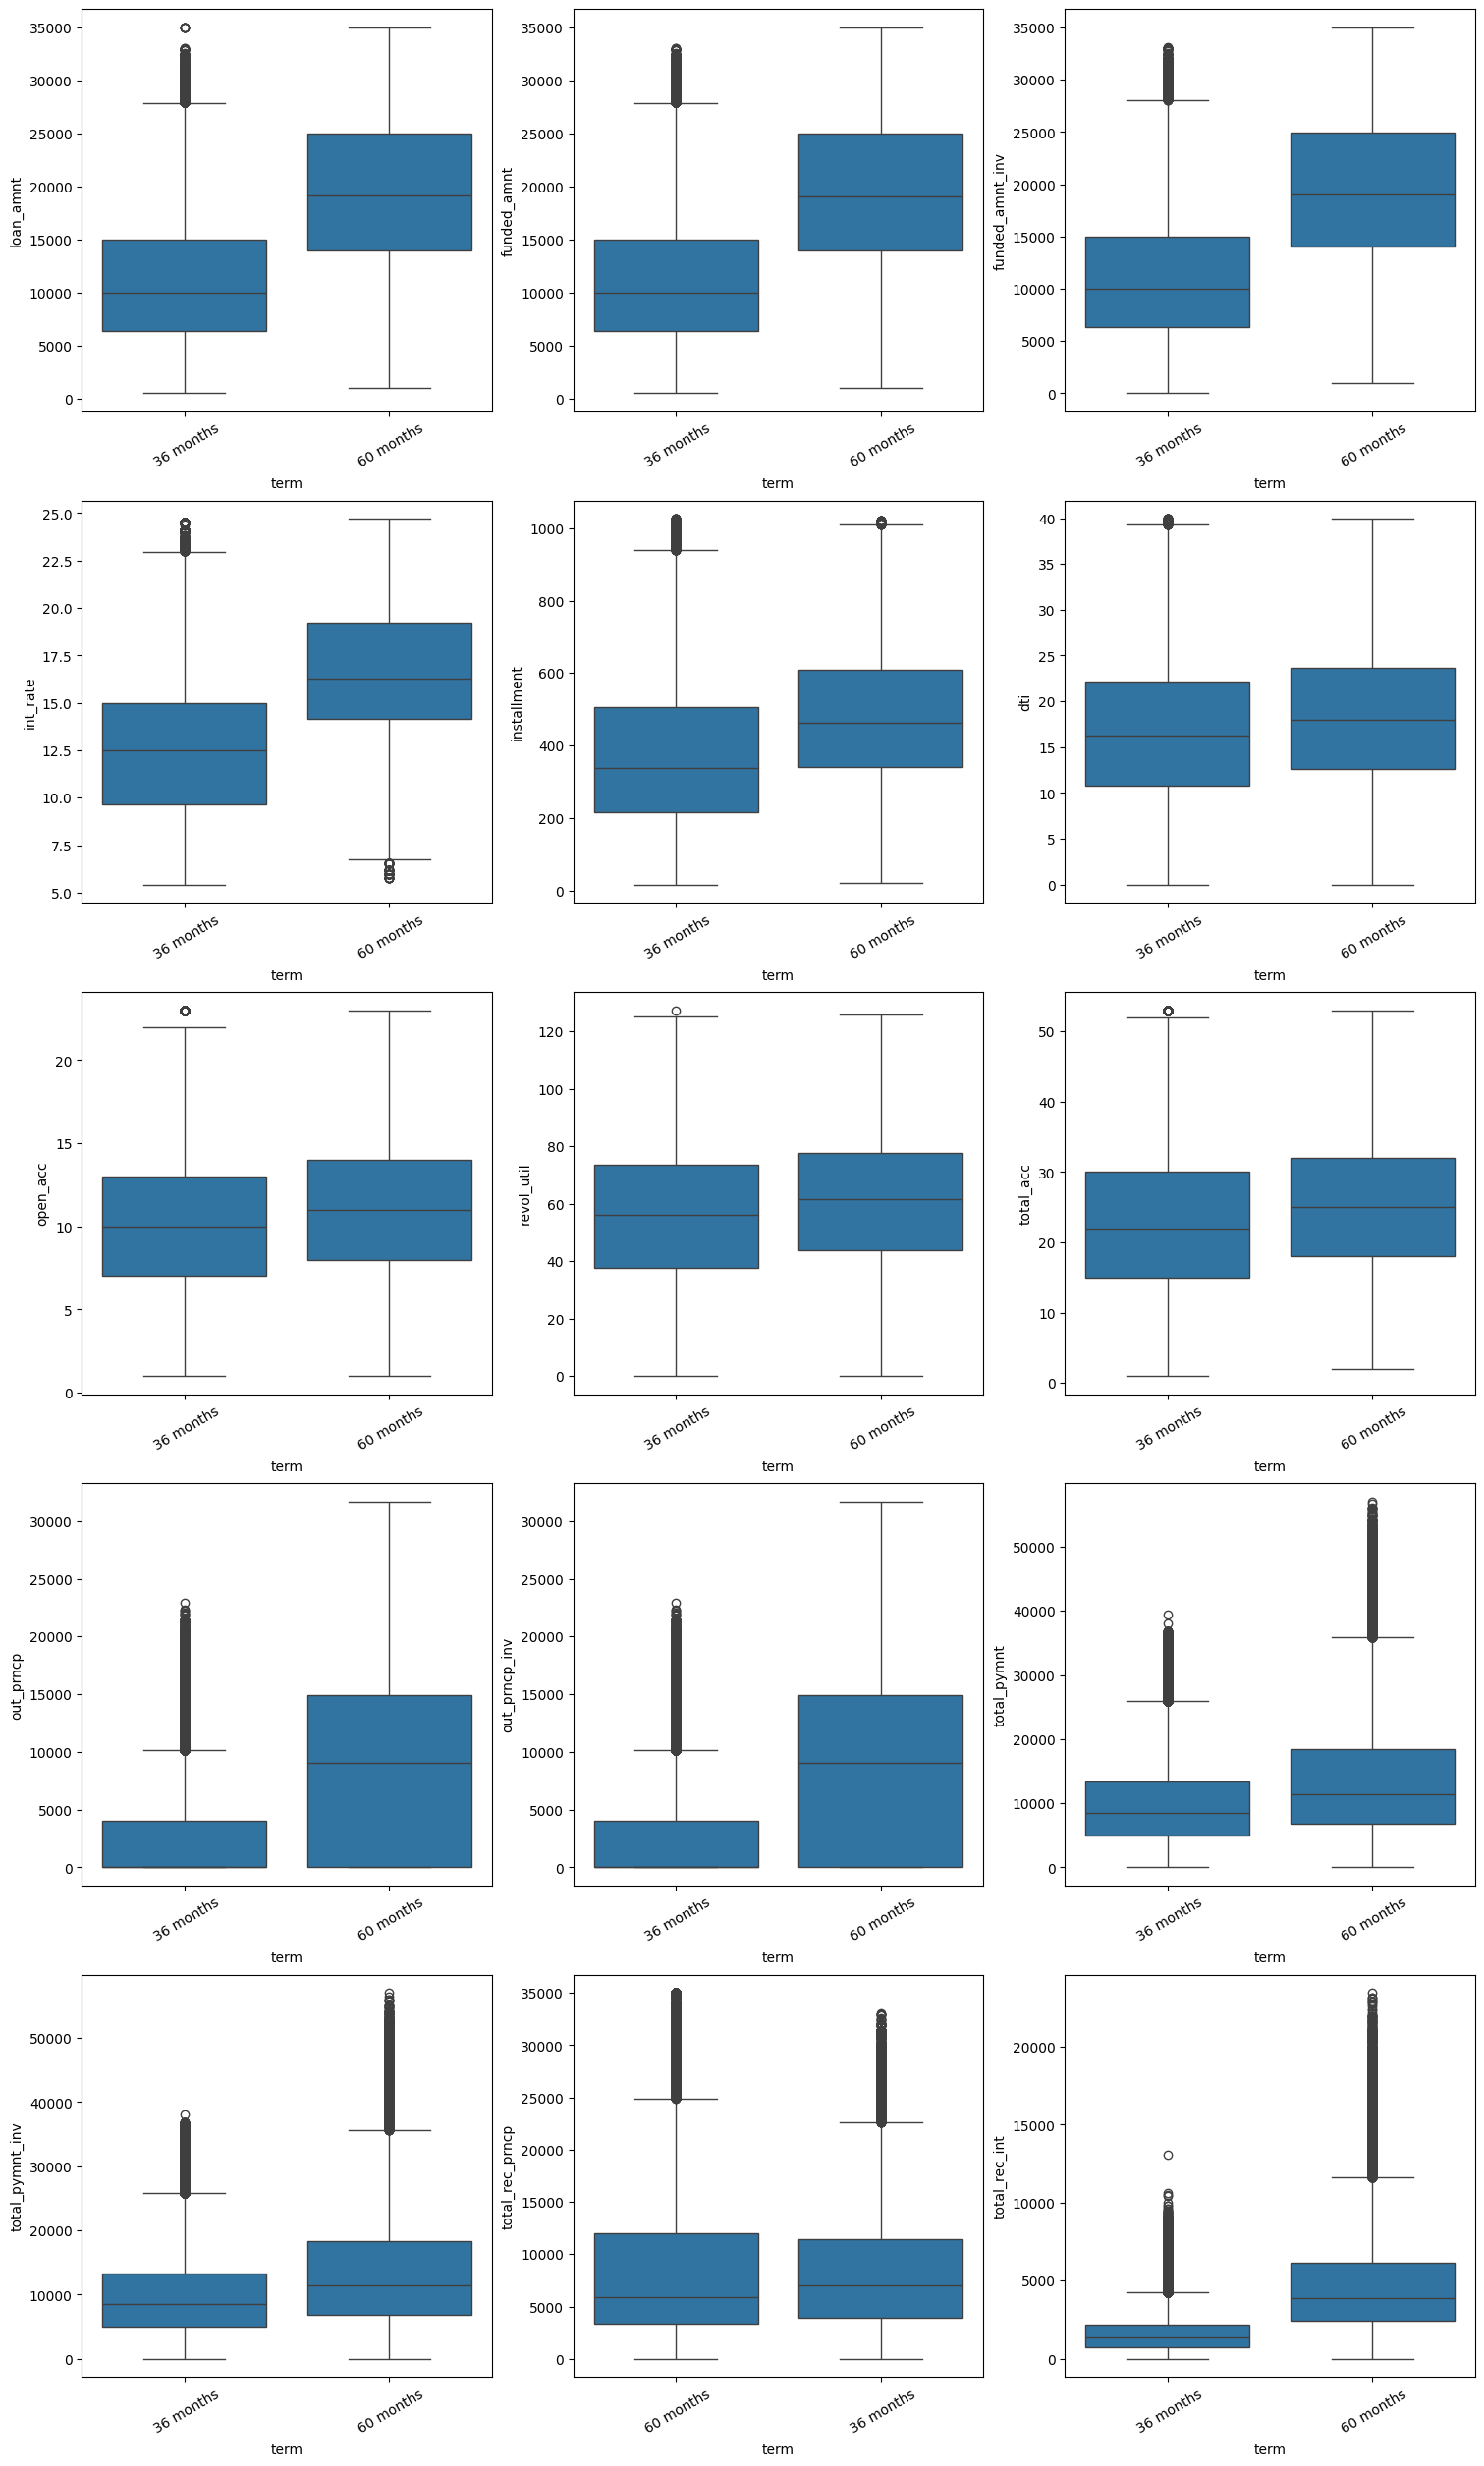

In [38]:
fig, axes = plt.subplots(5, 3, figsize=(15, 25), constrained_layout=True)

columns = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "dti", "open_acc",
           "revol_util", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", 
           "total_rec_prncp", "total_rec_int"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sorted_index = loan.groupby("term")[col].median().sort_values().index
    ax = sns.boxplot(data=loan, x="term", y=col, order=sorted_index, ax=axes[i][j])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    j += 1

C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\115473743.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\115473743.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\115473743.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\115473743.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get

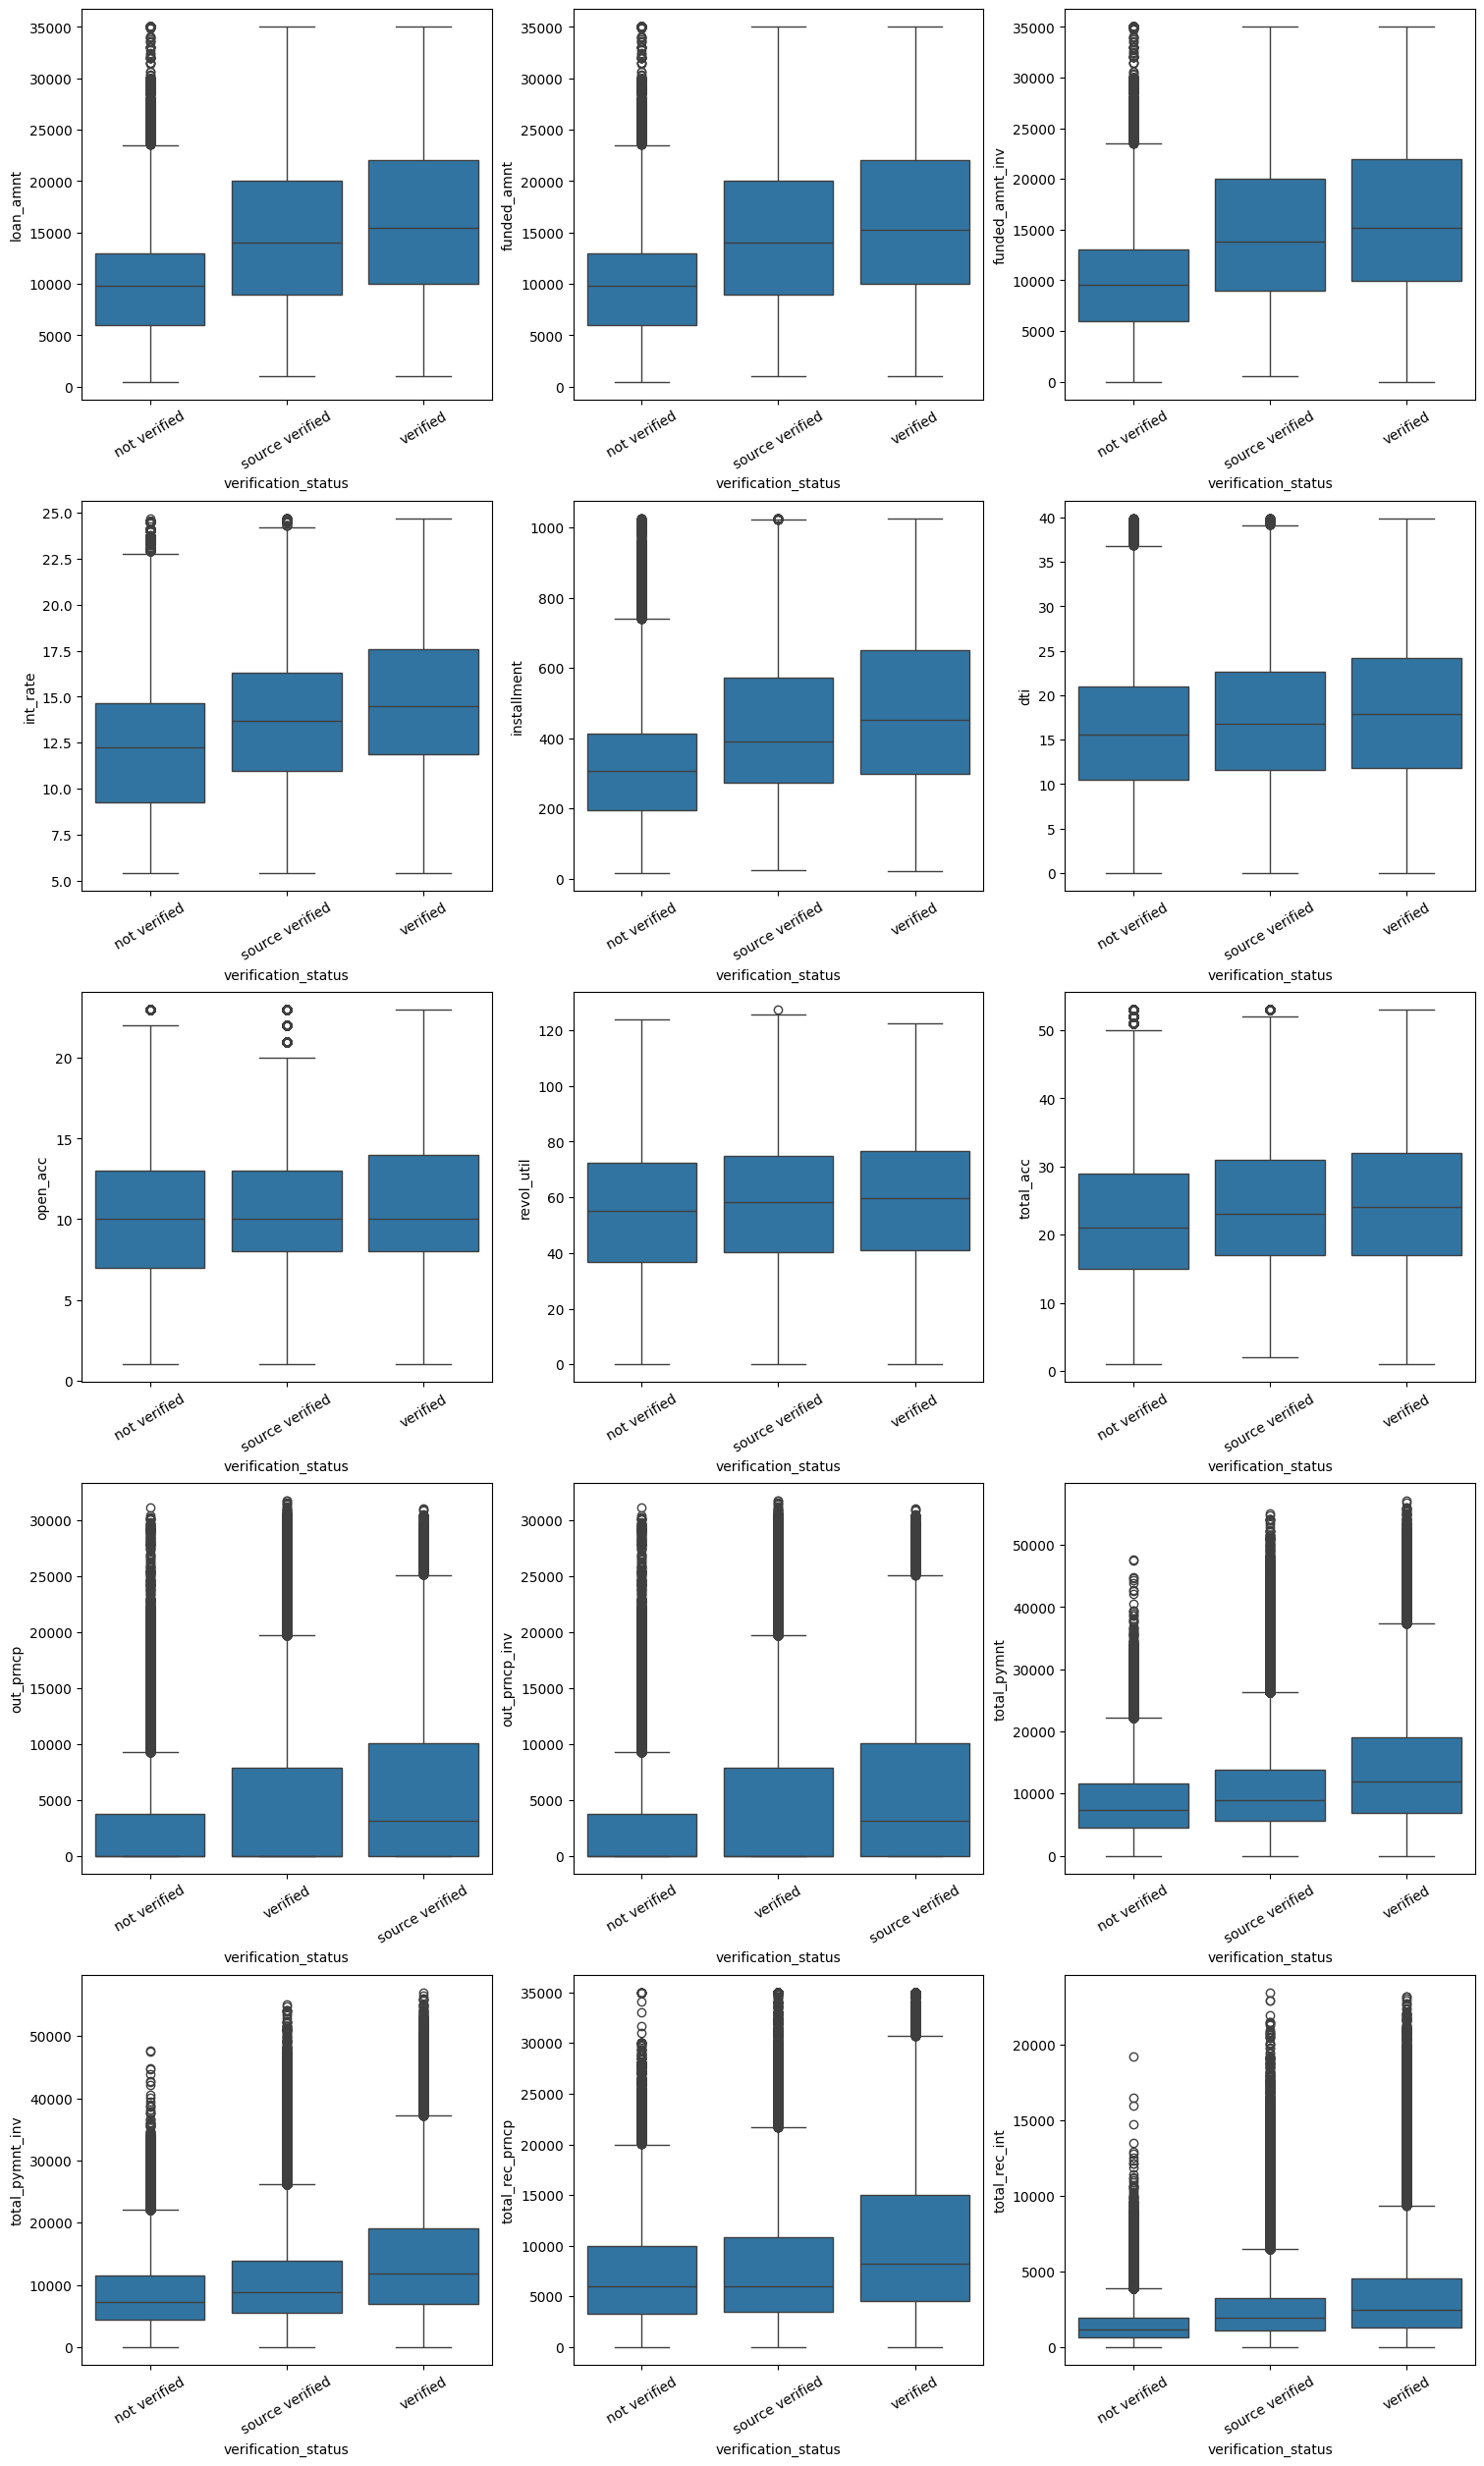

In [39]:
fig, axes = plt.subplots(5, 3, figsize=(15, 25), constrained_layout=True)

columns = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "dti", "open_acc",
           "revol_util", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", 
           "total_rec_prncp", "total_rec_int"]
i, j = 0, 0
for col in columns:
    if j % 3 == 0 and j != 0:
        i += 1
        j %= 3
    sorted_index = loan.groupby("verification_status")[col].median().sort_values().index
    ax = sns.boxplot(data=loan, x="verification_status", y=col, order=sorted_index, ax=axes[i][j])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    j += 1

C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\1104197314.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\1104197314.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\1104197314.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\1104197314.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax

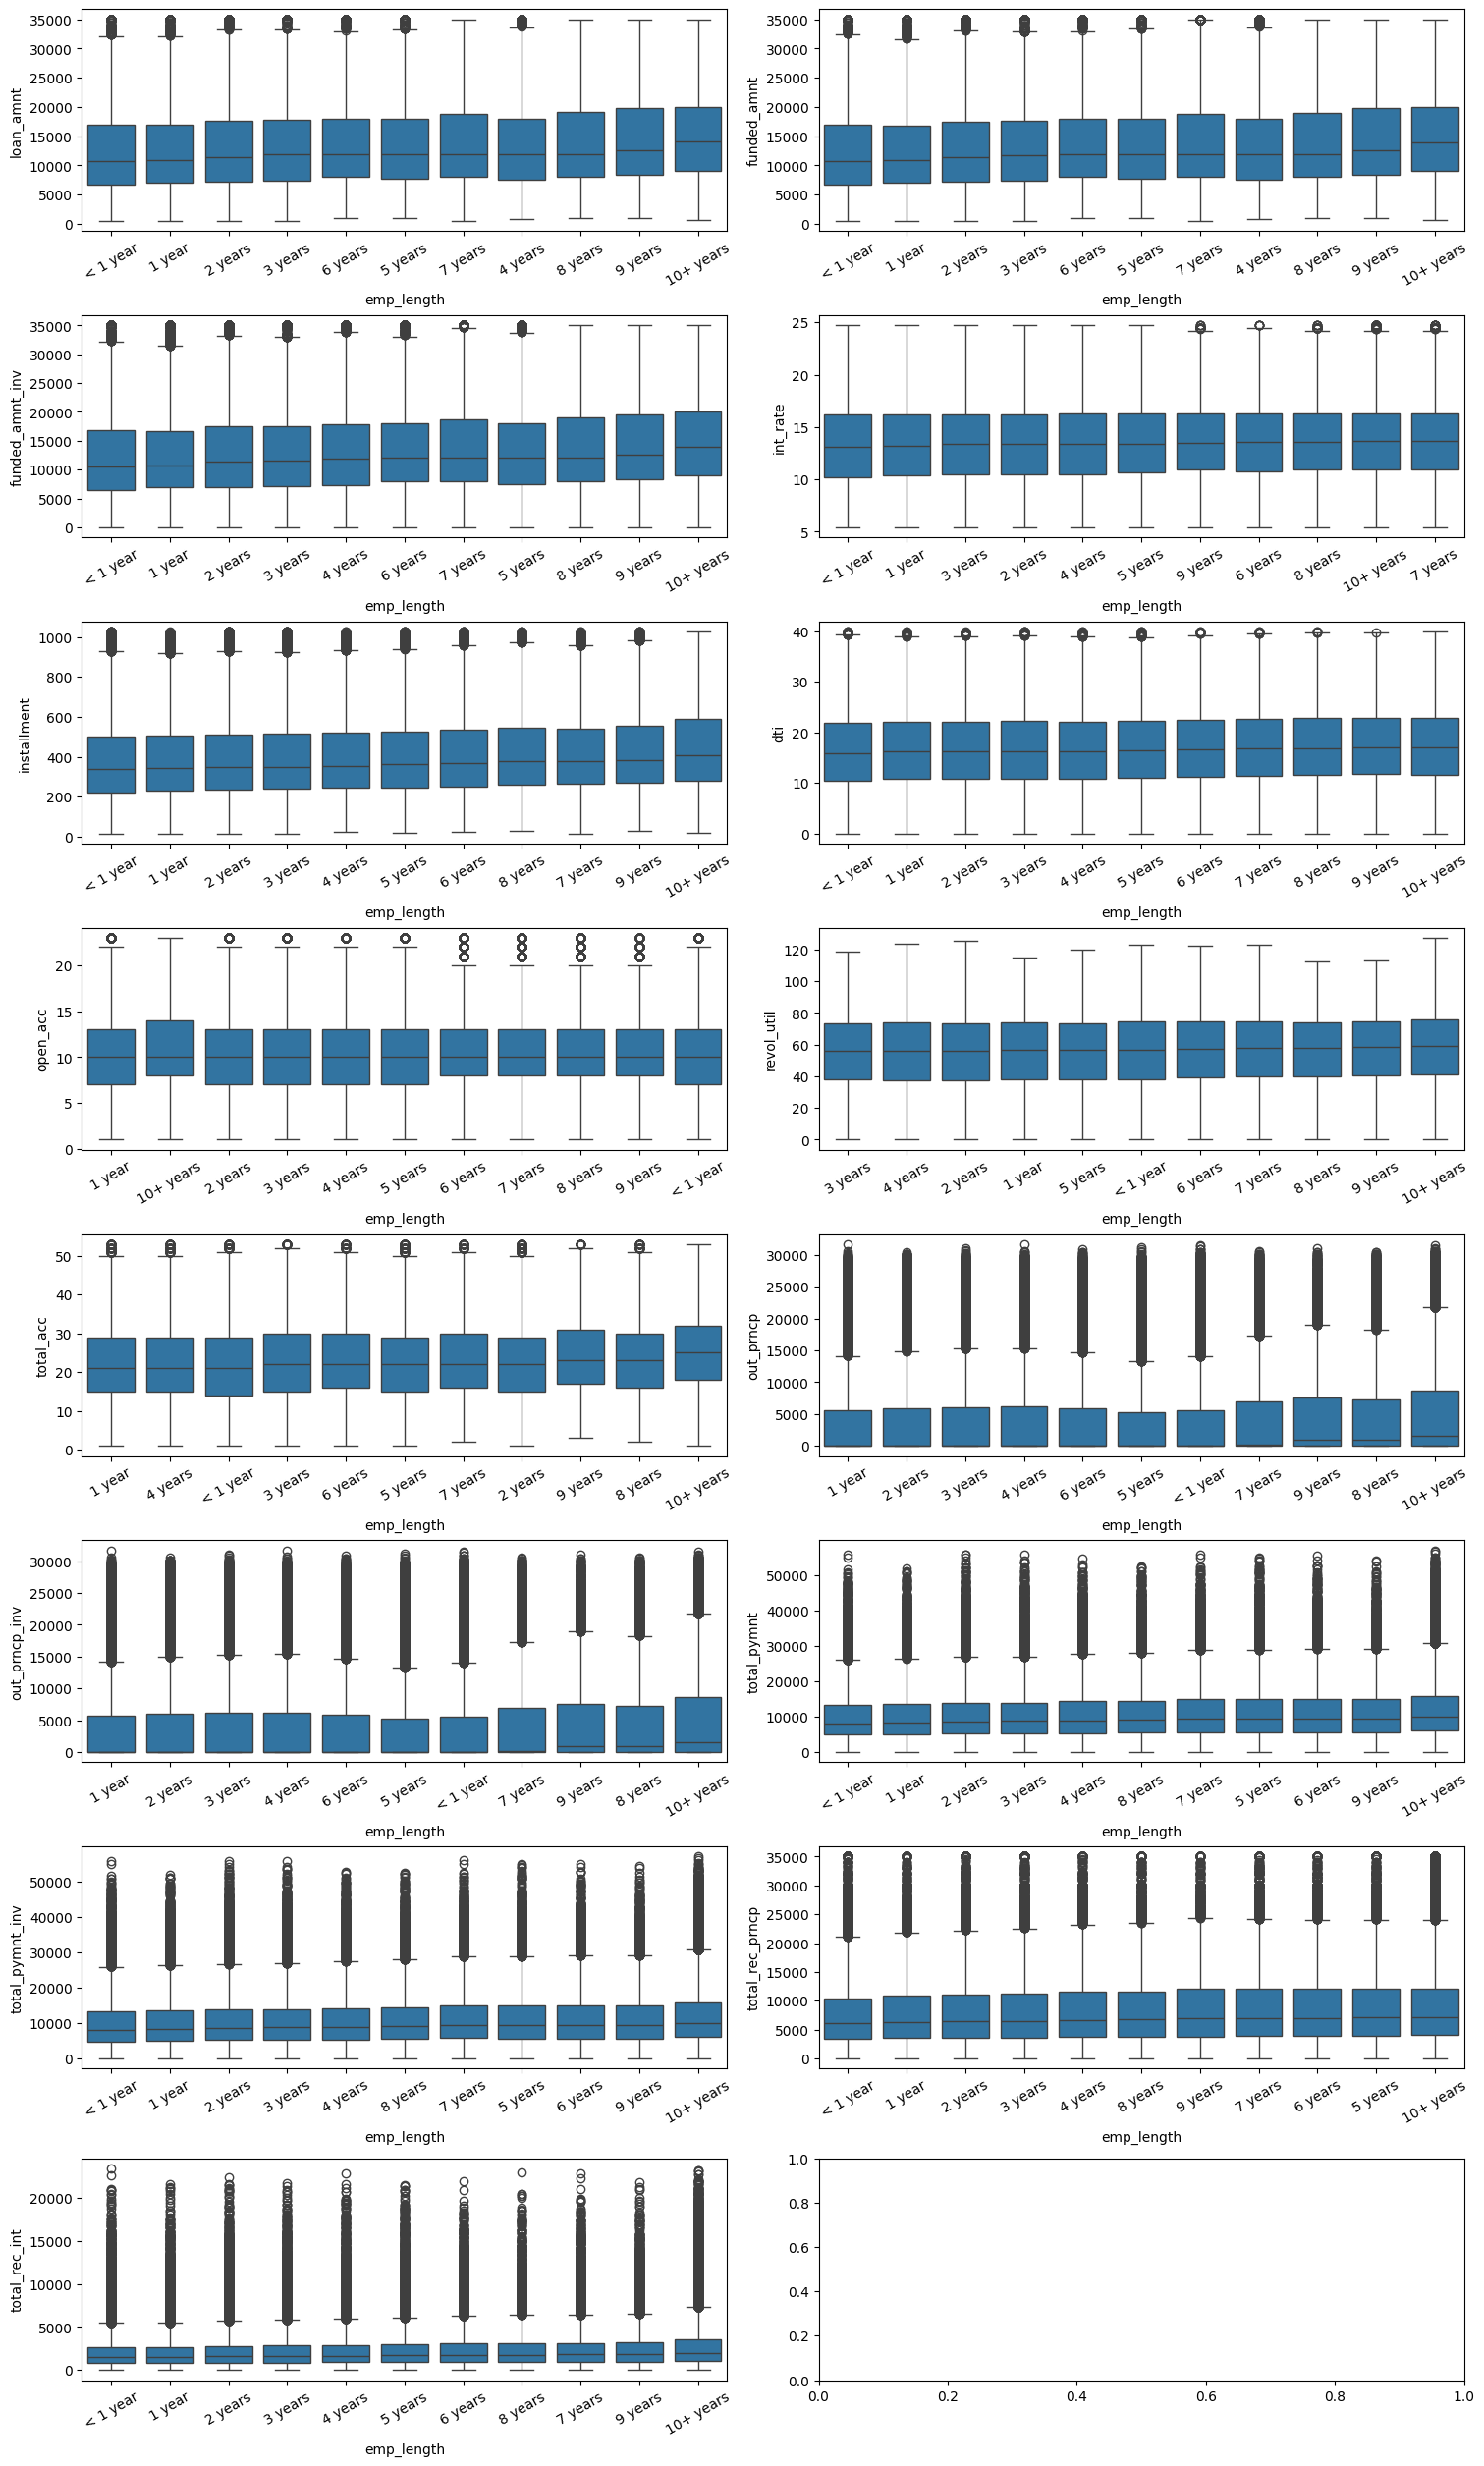

In [40]:
fig, axes = plt.subplots(8, 2, figsize=(15, 25), constrained_layout=True)

columns = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "dti", "open_acc",
           "revol_util", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", 
           "total_rec_prncp", "total_rec_int"]
i, j = 0, 0
for col in columns:
    if j % 2 == 0 and j != 0:
        i += 1
        j %= 2
    sorted_index = loan.groupby("emp_length")[col].median().sort_values().index
    ax = sns.boxplot(data=loan, x="emp_length", y=col, order=sorted_index, ax=axes[i][j])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    j += 1

In [41]:
loan["emp_length"].value_counts(dropna=False)

emp_length
10+ years    133352
2 years       37151
3 years       32863
< 1 year      32519
5 years       27985
1 year        26570
4 years       25289
7 years       23693
6 years       23637
8 years       20164
NaN           19328
9 years       16171
Name: count, dtype: int64

In [42]:
loan["home_ownership"].value_counts(dropna=False)

home_ownership
mortgage    209139
rent        172067
own          37314
other          161
none            40
any              1
Name: count, dtype: int64

In [43]:
loan["verification_status"].value_counts(dropna=False)

verification_status
verified           144817
not verified       139046
source verified    134859
Name: count, dtype: int64

In [44]:
loan["last_credit_pull_d"].value_counts(dropna=False)

last_credit_pull_d
jan-16    293792
dec-15     12254
nov-15      7620
sep-15      7286
oct-15      7261
           ...  
feb-08         3
nov-07         3
jun-08         1
may-08         1
jul-08         1
Name: count, Length: 101, dtype: int64

In [45]:
loan["issue_d"].value_counts(dropna=False)

issue_d
oct-14    34083
jul-14    25968
nov-14    22120
may-14    16989
apr-14    16879
          ...  
aug-08       92
oct-07       90
sep-08       53
sep-07       45
aug-07       18
Name: count, Length: 89, dtype: int64

In [46]:
loan["earliest_cr_line"].value_counts(dropna=False)

earliest_cr_line
oct-00    3310
aug-00    3229
aug-01    3138
oct-99    3030
nov-99    3014
          ... 
feb-60       1
may-62       1
mar-59       1
feb-61       1
may-50       1
Name: count, Length: 657, dtype: int64

In [47]:
loan["last_pymnt_d"].value_counts(dropna=False)

last_pymnt_d
jan-16    161254
dec-15     55244
jul-15     10380
oct-15      9951
sep-15      9076
           ...  
apr-08        19
mar-08        13
feb-08         7
jan-08         6
dec-07         2
Name: count, Length: 99, dtype: int64

In [48]:
loan["term"].value_counts(dropna=False)

term
36 months    304436
60 months    114286
Name: count, dtype: int64

In [49]:
loan["sub_grade"].unique()

array(['b2', 'c4', 'c5', 'b5', 'a4', 'e1', 'f2', 'c3', 'c1', 'b1', 'd1',
       'a1', 'b4', 'b3', 'c2', 'd2', 'a3', 'a5', 'd5', 'a2', 'e4', 'd3',
       'd4', 'f3', 'e3', 'f4', 'f1', 'e5', 'g4', 'e2', 'g3', 'g1', 'f5',
       'g5', 'g2'], dtype=object)

In [50]:
loan["grade"].value_counts(dropna=False)

grade
b    126307
c    112317
a     70403
d     68143
e     31431
f      9494
g       627
Name: count, dtype: int64

In [51]:
loan["loan_status"].value_counts(dropna=False)

loan_status
current                                                202033
fully paid                                             169666
charged off                                             35490
late (31-120 days)                                       5235
in grace period                                          2426
does not meet the credit policy. status:fully paid       1681
late (16-30 days)                                         938
default                                                   678
does not meet the credit policy. status:charged off       575
Name: count, dtype: int64

# D. Feature Engineering

In [52]:
def feature_engineering(df):
    
    # Fitur emp_length
    df["emp_length"].fillna(df["emp_length"].mode()[0], inplace=True)
    df = df.astype({"emp_length": "string"})
    df["emp_length"] = df["emp_length"].apply(lambda x: x.replace("< ", "<").replace("+", "").split(" ")[0].replace("<1", "0"))
    df = df.astype({"emp_length": "int64"})
    
    # Fitur home_ownership
    df["home_ownership"] = df["home_ownership"].apply(lambda x: x.replace("any", "other").replace("none", "other"))
    df["home_ownership"] = df["home_ownership"].apply(lambda x: x.replace("other", "mortgage"))
    df["home_ownership"] = df["home_ownership"].apply(lambda x: x.replace("own", "1").replace("rent", "2")
                                                      .replace("mortgage", "3"))
    df = df.astype({"home_ownership": "int64"})
    
    # Fitur verification_status
    df["verification_status"] = df["verification_status"].apply(lambda x: x.replace("source verified", "verified"))
    df["verification_status"] = np.where(df["verification_status"] == "verified", 1, 0)
    df = df.astype({"verification_status": "int64"})
    
    # Fitur last_credit_pull_d
    def last_pull_month(x):
        month, year = x.split("-")
        year = int(year)

        month_list = ["dec", "nov", "oct", "sep", "aug", "jul", 
                      "jun", "may", "apr", "mar", "feb", "jan"]
        month_range = month_list.index(month) + 1
        year_to_month = (15 - year)*12

        month_count = month_range + year_to_month
        return month_count
    
    df["last_credit_pull_d"].fillna(df["last_credit_pull_d"].mode()[0], inplace=True)
    df = df.astype({"last_credit_pull_d": "string"})
    df["last_credit_pull_d"] = df["last_credit_pull_d"].apply(lambda x: last_pull_month(x))
    
    # Fitur issue_d
    def issue_month(x):
        month, year = x.split("-")
        year = int(year)

        month_list = ["dec", "nov", "oct", "sep", "aug", "jul", 
                      "jun", "may", "apr", "mar", "feb", "jan"]
        month_range = month_list.index(month)
        year_to_month = (14 - year)*12

        month_count = month_range + year_to_month
        return month_count

    df = df.astype({"issue_d": "string"})
    df["issue_d"] = df["issue_d"].apply(lambda x: issue_month(x))
    
    # Fitur earliest_cr_line
    def earliest_cr_month(x):
        month, year = x.split("-")
        year = int(year)

        month_list = ["dec", "nov", "oct", "sep", "aug", "jul", 
                      "jun", "may", "apr", "mar", "feb", "jan"]
        month_range = month_list.index(month) - 1
        if year <= 11: 
            year_to_month = (11 - year)*12
        else:
            year_to_month = ((100 - year) + 11)*12

        month_count = month_range + year_to_month
        return month_count

    df = df.astype({"earliest_cr_line": "string"})
    df["earliest_cr_line"] = df["earliest_cr_line"].apply(lambda x: earliest_cr_month(x))
    
    # Fitur last_pymnt_d
    def last_pymnt_month(x):
        month, year = x.split("-")
        year = int(year)

        month_list = ["dec", "nov", "oct", "sep", "aug", "jul", 
                      "jun", "may", "apr", "mar", "feb", "jan"]
        month_range = month_list.index(month) + 1
        year_to_month = (15 - year)*12

        month_count = month_range + year_to_month
        return month_count

    df["last_pymnt_d"].fillna(df["last_pymnt_d"].mode()[0], inplace=True)
    df = df.astype({"last_pymnt_d": "string"})
    df["last_pymnt_d"] = df["last_pymnt_d"].apply(lambda x: last_pymnt_month(x))
    
    # Fitur term
    df["term"] = df["term"].apply(lambda x: x.split(" ")[1])
    df = df.astype({"term": "int64"})
    
    # Fitur sub_grade
    def rank_sub_grade(x):
        letter, number = x[0], x[1]
        number = int(number)

        letter_list = ["a", "b", "c", "d", "e", "f", "g"]
        letter_to_number = letter_list.index(letter)*5

        number_rank = number + letter_to_number
        return number_rank

    df["sub_grade"] = df["sub_grade"].apply(lambda x: rank_sub_grade(x))
    
    # Fitur grade
    def rank_grade(x):
        letter_list = ["a", "b", "c", "d", "e", "f", "g"]
        number_rank = letter_list.index(x) + 1
        return number_rank

    df["grade"] = df["grade"].apply(lambda x: rank_grade(x))
    
    # Fitur baru: target (untuk modelling) sebagai ganti dari fitur loan_status
    # status "current", "default", dan "in grace period" tidak dimasukkan karena target belum dapat dinilai (good atau bad)
    df = df[df["loan_status"] != "current"]  
    df = df[df["loan_status"] != "default"]
    df = df[df["loan_status"] != "in grace period"] 
    df["target"] = "good"
    df.loc[(loan["loan_status"] == "charged off") | 
           (loan["loan_status"] == "late (31-120 days)") | 
           (loan["loan_status"] == "late (16-30 days)") | 
           (loan["loan_status"] == "does not meet the credit policy. status:charged off"), "target"] = "bad"

    df["target"] = np.where(df["target"] == "good", 0, 1) # 1: bad, 0: good
        
    # Membuang fitur loan_status karena sudah digantikan oleh target, agar tidak "membantu" pelatihan model
    df.drop("loan_status", axis=1, inplace=True)
    
    return df

In [53]:
loan = feature_engineering(loan)
loan.shape, loan.info()

C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\2265977291.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["emp_length"].fillna(df["emp_length"].mode()[0], inplace=True)
C:\Users\Habiburrohman\AppData\Local\Temp\ipykernel_9888\2265977291.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

<class 'pandas.core.frame.DataFrame'>
Index: 213585 entries, 0 to 466283
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   213585 non-null  int64  
 1   funded_amnt                 213585 non-null  int64  
 2   funded_amnt_inv             213585 non-null  float64
 3   term                        213585 non-null  int64  
 4   int_rate                    213585 non-null  float64
 5   installment                 213585 non-null  float64
 6   grade                       213585 non-null  int64  
 7   sub_grade                   213585 non-null  int64  
 8   emp_length                  213585 non-null  int64  
 9   home_ownership              213585 non-null  int64  
 10  annual_inc                  213585 non-null  float64
 11  verification_status         213585 non-null  int64  
 12  issue_d                     213585 non-null  int64  
 13  purpose            

((213585, 40), None)

In [54]:
plt.figure(figsize=(20, 20))
sns.heatmap(loan.corr(), annot=True, fmt=".2f")

ValueError: could not convert string to float: 'credit_card'

<Figure size 2000x2000 with 0 Axes>

In [ ]:
loan["collections_12_mths_ex_med"].value_counts(dropna=False)

0.0    213585
Name: collections_12_mths_ex_med, dtype: int64

In [ ]:
loan["total_rec_late_fee"].value_counts(dropna=False)

0.0    213585
Name: total_rec_late_fee, dtype: int64

In [ ]:
loan["acc_now_delinq"].value_counts(dropna=False)

0.0    213585
Name: acc_now_delinq, dtype: int64

# E. Data Cleaning 2

In [ ]:
def cleaning_after_fe(df):
    # Semuanya 0
    df.drop("collections_12_mths_ex_med", axis=1, inplace=True)
    df.drop("total_rec_late_fee", axis=1, inplace=True)
    df.drop("acc_now_delinq", axis=1, inplace=True)
    
    return df

In [ ]:
loan = cleaning_after_fe(loan)
loan.shape, loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213585 entries, 0 to 466283
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   loan_amnt                213585 non-null  int64  
 1   funded_amnt              213585 non-null  int64  
 2   funded_amnt_inv          213585 non-null  float64
 3   term                     213585 non-null  int64  
 4   int_rate                 213585 non-null  float64
 5   installment              213585 non-null  float64
 6   grade                    213585 non-null  int64  
 7   sub_grade                213585 non-null  int64  
 8   emp_length               213585 non-null  int64  
 9   home_ownership           213585 non-null  int64  
 10  annual_inc               213585 non-null  float64
 11  verification_status      213585 non-null  int64  
 12  issue_d                  213585 non-null  int64  
 13  purpose                  213585 non-null  object 
 14  addr

((213585, 37), None)

<AxesSubplot:>

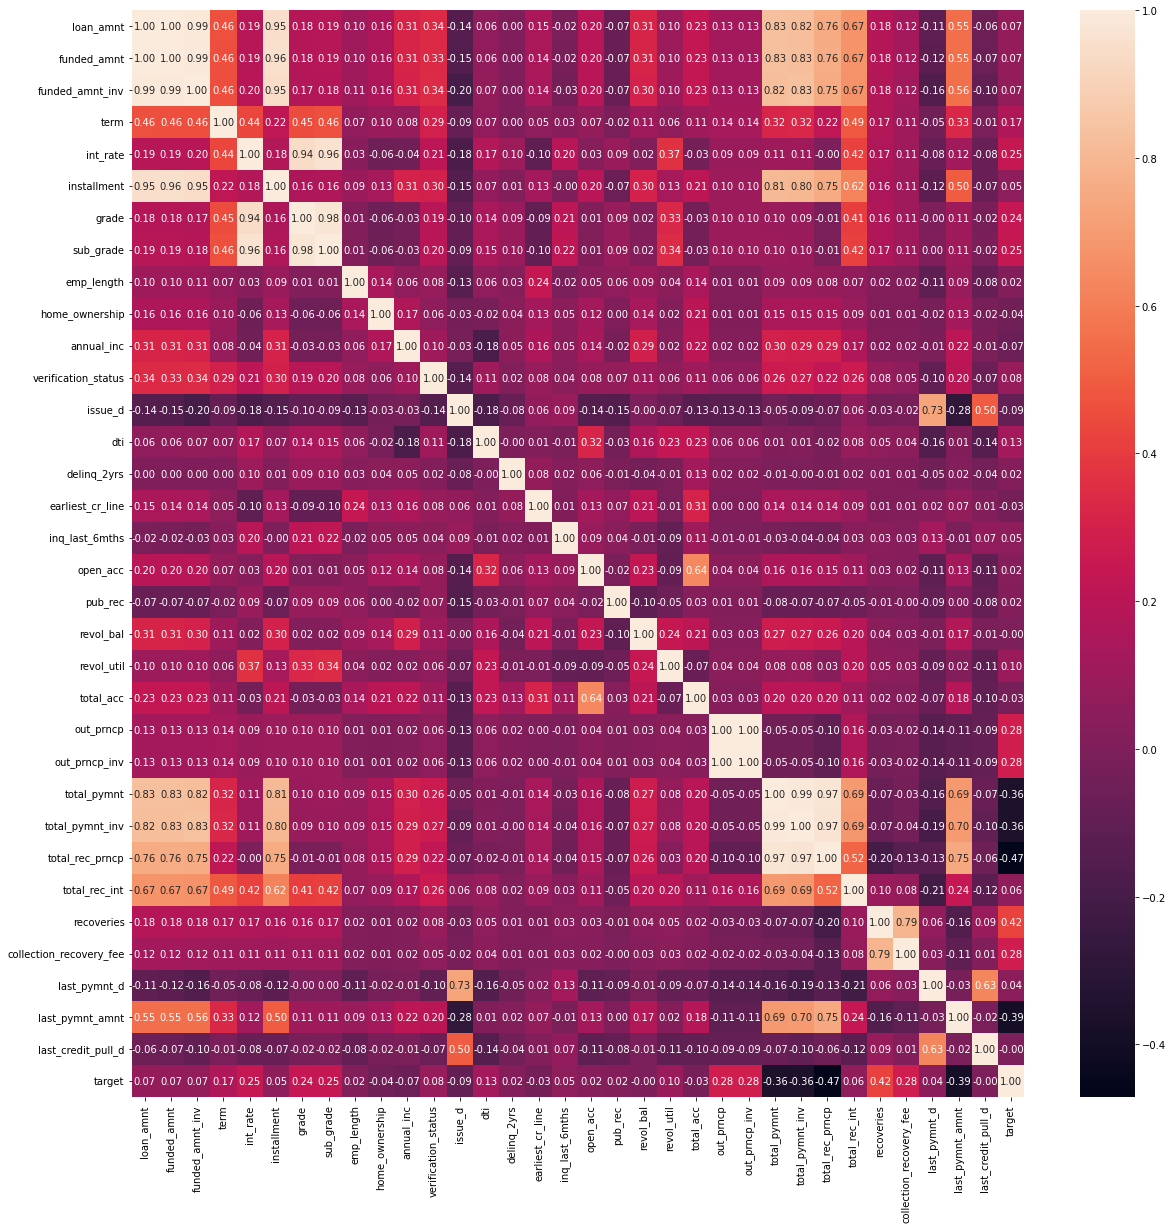

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(loan.corr(), annot=True, fmt=".2f")

In [ ]:
loan["purpose"].value_counts(dropna=False)

debt_consolidation    124027
credit_card            43227
home_improvement       12267
other                  12141
major_purchase          5472
small_business          3980
car                     3261
medical                 2406
wedding                 1888
moving                  1695
vacation                1353
house                   1286
educational              354
renewable_energy         228
Name: purpose, dtype: int64

In [ ]:
loan["addr_state"].unique()

array(['az', 'ga', 'il', 'ca', 'tx', 'va', 'mo', 'ct', 'fl', 'ny', 'pa',
       'mn', 'nj', 'or', 'ky', 'oh', 'sc', 'ri', 'la', 'ma', 'wa', 'wi',
       'al', 'nv', 'co', 'md', 'wv', 'vt', 'mi', 'dc', 'sd', 'nc', 'ar',
       'nm', 'ks', 'hi', 'ak', 'ut', 'ok', 'mt', 'wy', 'nh', 'de', 'ms',
       'tn', 'ne', 'id', 'ia', 'in', 'me'], dtype=object)

In [ ]:
loan["initial_list_status"].value_counts(dropna=False)

f    159864
w     53721
Name: initial_list_status, dtype: int64

# F. Categorical Feature Encoding

In [71]:
def feature_encoding(df):
    label_encoder = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = label_encoder.fit_transform(df[col])
            df = df.astype({col: "int64"})
        
    return df

In [72]:
loan = feature_encoding(loan)
loan.shape, loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213585 entries, 0 to 466283
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   213585 non-null  int64  
 1   funded_amnt                 213585 non-null  int64  
 2   funded_amnt_inv             213585 non-null  float64
 3   term                        213585 non-null  int64  
 4   int_rate                    213585 non-null  float64
 5   installment                 213585 non-null  float64
 6   grade                       213585 non-null  int64  
 7   sub_grade                   213585 non-null  int64  
 8   emp_length                  213585 non-null  int64  
 9   home_ownership              213585 non-null  int64  
 10  annual_inc                  213585 non-null  float64
 11  verification_status         213585 non-null  int64  
 12  issue_d                     213585 non-null  int64  
 13  purpose            

((213585, 40), None)

<Axes: >

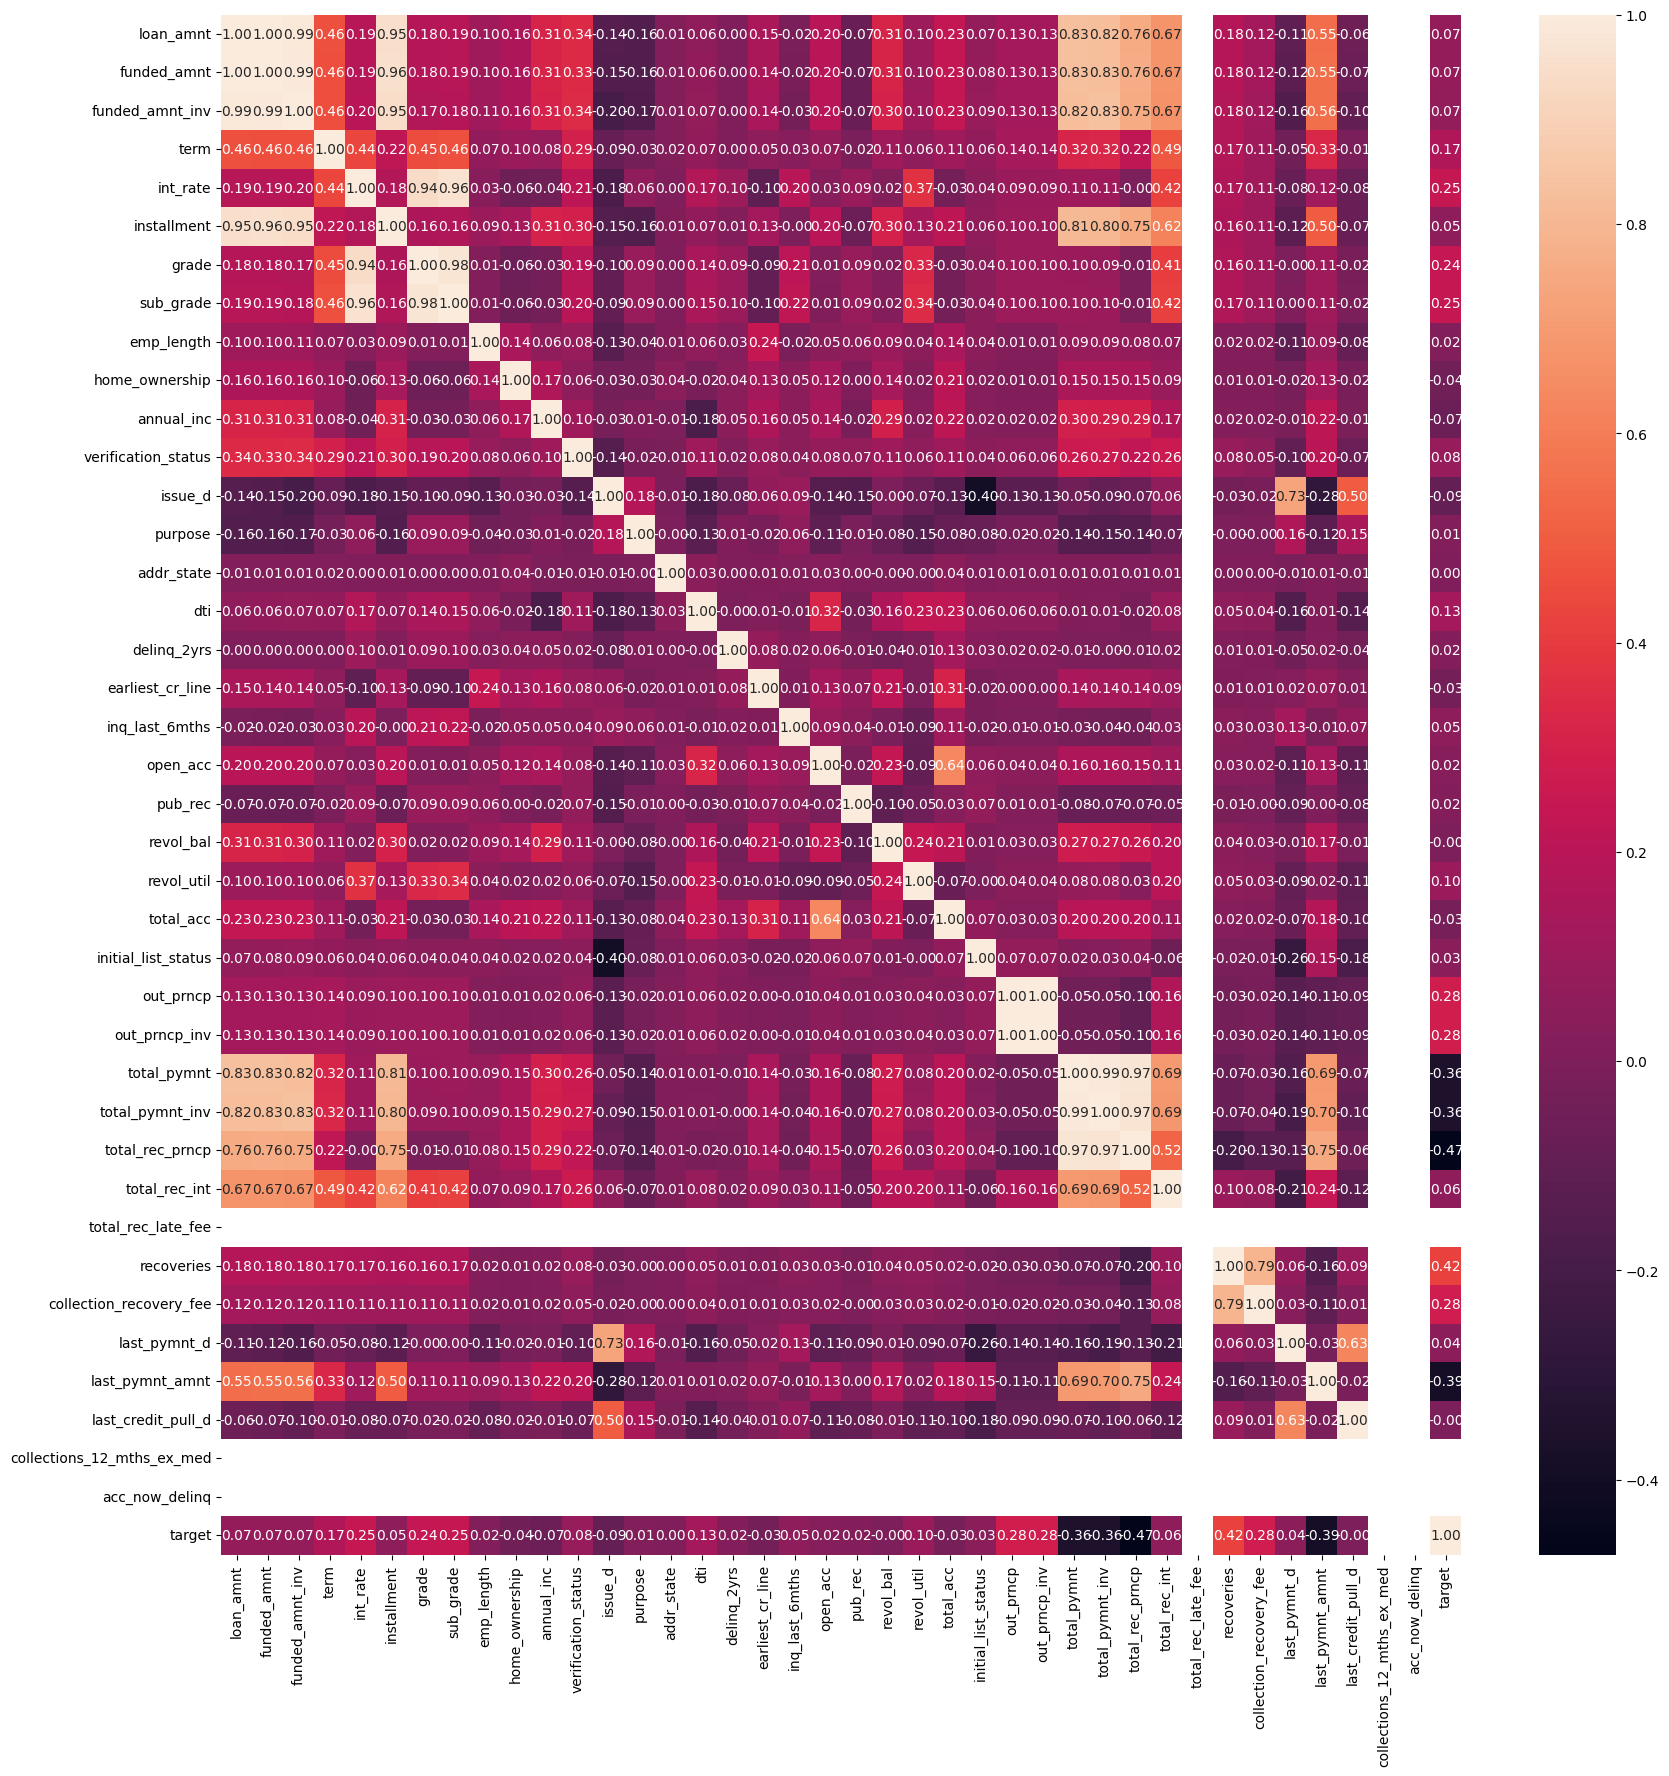

In [73]:
plt.figure(figsize=(20, 20))
sns.heatmap(loan.corr(), annot=True, fmt=".2f")

In [74]:
# Memeriksa value_counts() setiap fitur
for col in loan.columns:
    print(col, loan[col].nunique())
    if loan[col].nunique() > 15:
        print(loan[col].value_counts().head(15))
    else:
        print(loan[col].value_counts())
    print()

loan_amnt 1268
loan_amnt
10000    16090
12000    12326
15000    10411
20000     9511
8000      7686
6000      7419
5000      6990
16000     5412
18000     5006
25000     4702
7000      4064
24000     3887
4000      3518
14000     3405
9000      3213
Name: count, dtype: int64

funded_amnt 1269
funded_amnt
10000    16003
12000    12239
15000    10312
20000     9342
8000      7673
6000      7408
5000      6975
16000     5336
18000     4945
25000     4463
7000      4054
24000     3811
4000      3517
14000     3372
9000      3203
Name: count, dtype: int64

funded_amnt_inv 8661
funded_amnt_inv
10000.0    13114
12000.0     9811
15000.0     7991
20000.0     6777
8000.0      6515
6000.0      6367
5000.0      5973
16000.0     4162
18000.0     3804
7000.0      3391
4000.0      3085
25000.0     2945
24000.0     2848
3000.0      2739
14000.0     2678
Name: count, dtype: int64

term 2
term
36    167970
60     45615
Name: count, dtype: int64

int_rate 491
int_rate
12.12    7196
8.90     6298
13.11   

# G. Feature Selection

In [75]:
# Membagi data menjadi data independen (x) dan data dependen (y)
x = loan.drop("target", axis=1)
y = loan["target"]
x.shape, y.shape

((213585, 39), (213585,))

In [77]:
def feature_selection(x, y, max_f):
    n = len(x.columns)
    model_rf = RandomForestClassifier()
    rfe = RFE(estimator=model_rf, n_features_to_select=n-1, verbose=1)
    selection = rfe.fit(x, y)
    x_new = x.iloc[:,selection.support_]
    selected_features = selection.get_feature_names_out()
    eliminated_feature = set(x.columns) - set(selected_features)
    
    print("Features count: {}".format(selection.n_features_))
    print("Selected features: \n{}".format(selection.get_feature_names_out()))
    print("Eliminated feature: {}".format(eliminated_feature))
    print()
    
    if selection.n_features_ > max_f:
        return feature_selection(x=x_new, y=y, max_f=max_f)
    else:
        return x_new, y, selected_features.tolist()

In [78]:
x.shape, y.shape

((213585, 39), (213585,))

In [83]:
# x_new, y, selected_features = feature_selection(x=x, y=y, max_f=25)

In [82]:
# selected_features_df = pd.DataFrame({"selected_features": selected_features})
# selected_features_df

In [ ]:
# Karena proses seleksi fitur cukup lama, saya menunjukkan hasilnya (25 fitur) di bawah ini agar memudahkan

# x_new = x[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 
#            'installment', 'grade', 'sub_grade', 'annual_inc', 'issue_d', 'dti', 
#            'earliest_cr_line', 'revol_bal', 'initial_list_status', 'out_prncp', 
#            'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
#            'total_rec_int', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 
#            'last_pymnt_amnt', 'last_credit_pull_d']]

<Axes: >

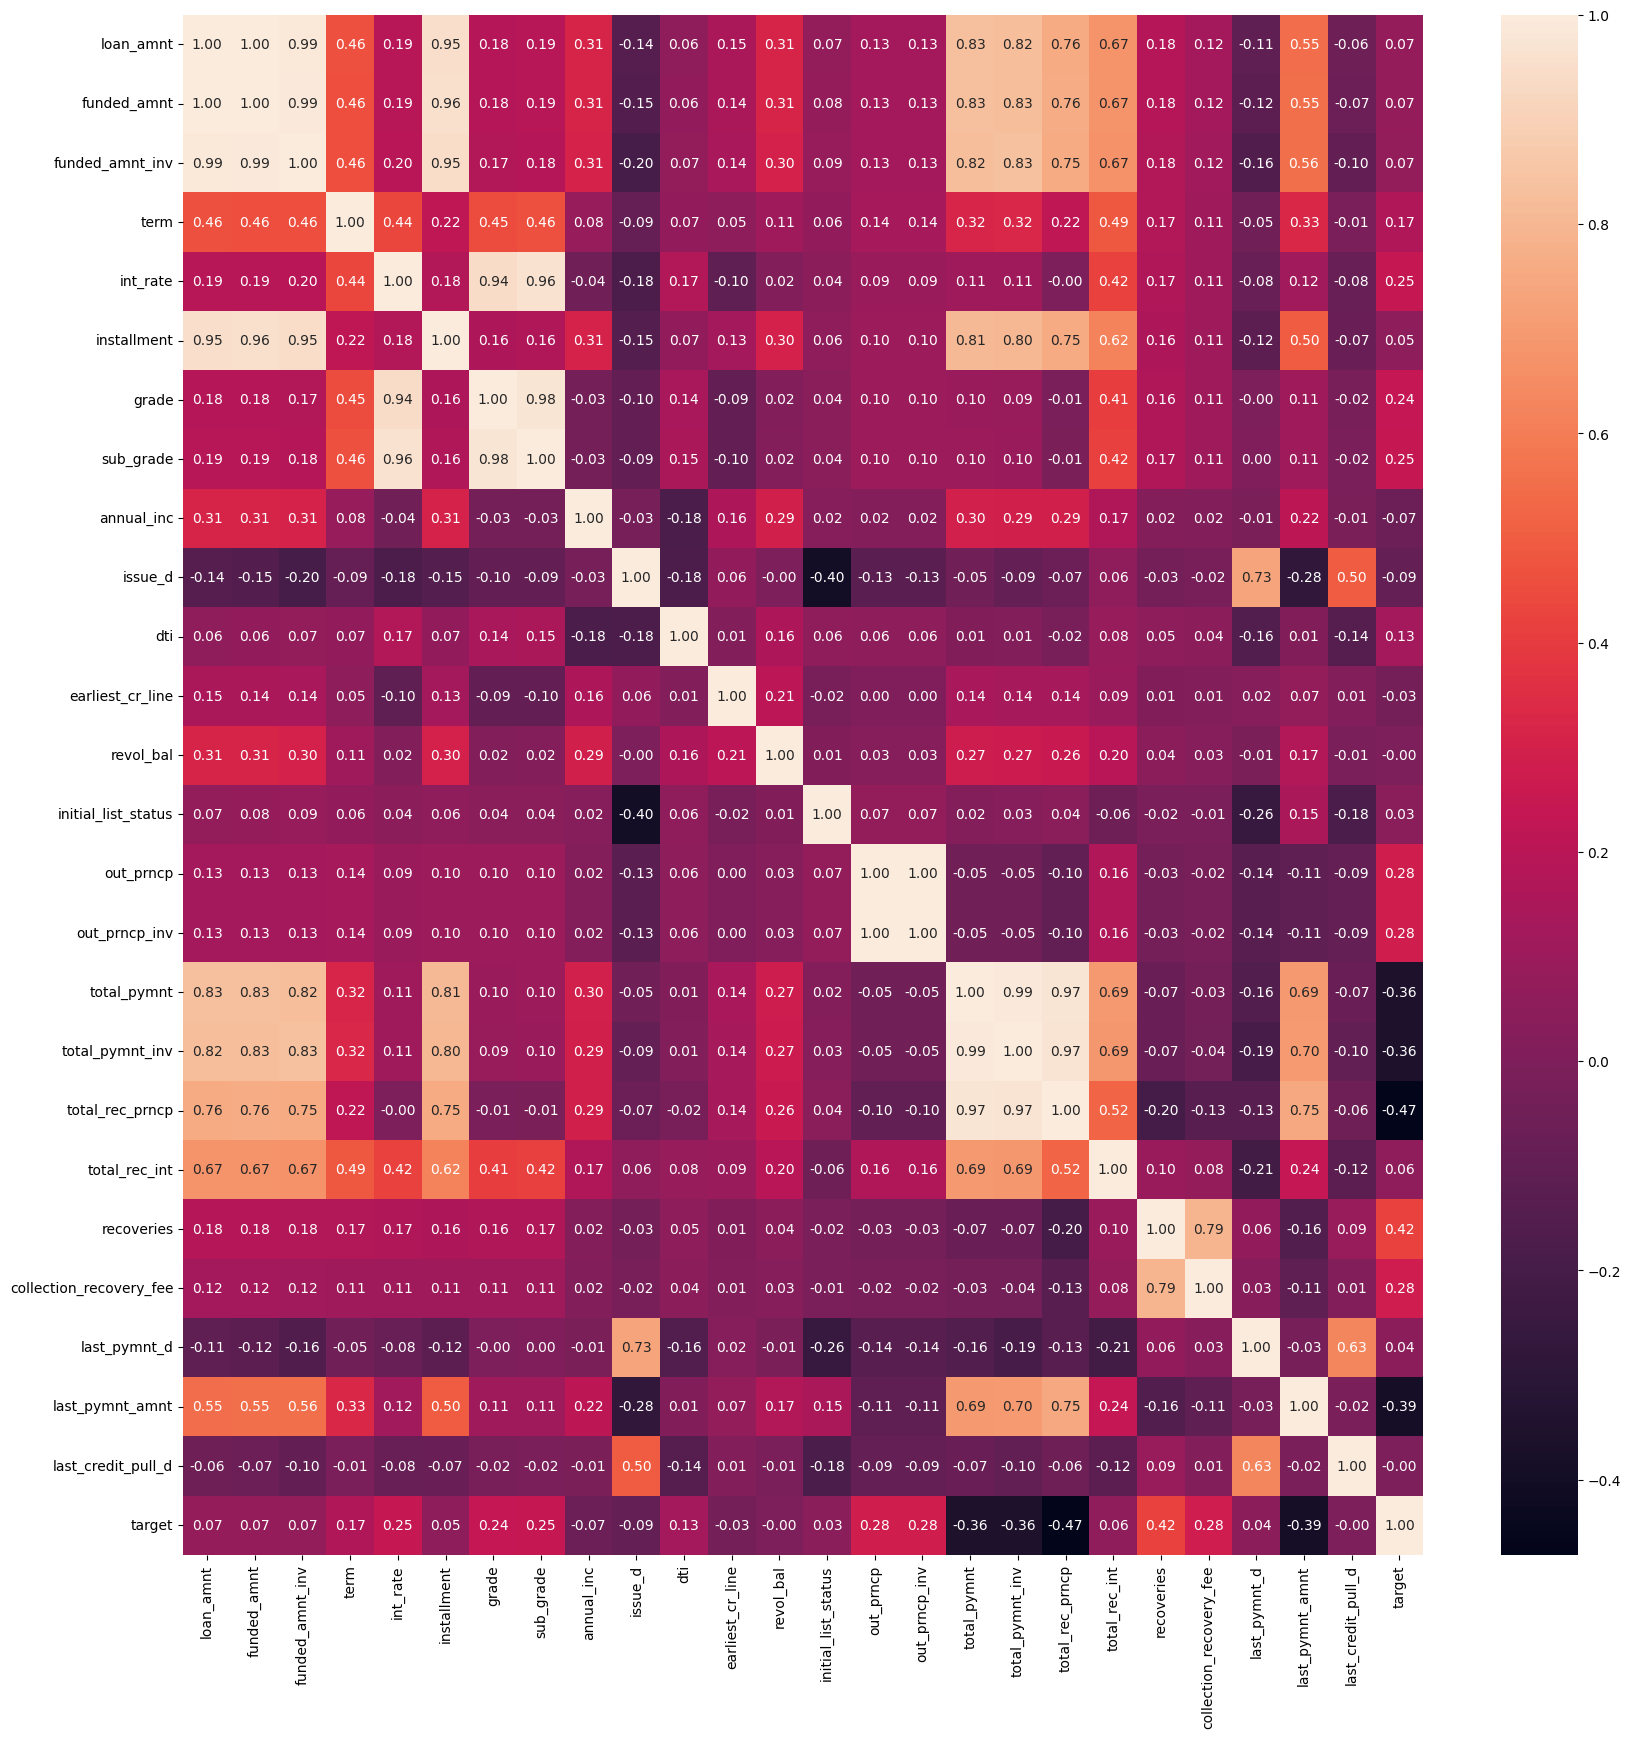

In [84]:
loan_new = loan[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 
           'installment', 'grade', 'sub_grade', 'annual_inc', 'issue_d', 'dti', 
           'earliest_cr_line', 'revol_bal', 'initial_list_status', 'out_prncp', 
           'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
           'total_rec_int', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 
           'last_pymnt_amnt', 'last_credit_pull_d', 'target']]
plt.figure(figsize=(20, 20))
sns.heatmap(loan_new.corr(), annot=True, fmt=".2f")

# H. Modelling

In [86]:
# Membagi data menjadi data train dan data test
x_train, x_test, y_train, y_test = train_test_split(loan.drop(['target'], axis=1), loan['target'], test_size=0.20, random_state=21)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((170868, 39), (170868,), (42717, 39), (42717,))

In [87]:
# Penskalaan fitur
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

In [88]:
# Membuat model
model = RandomForestClassifier(random_state=21)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
model.score(x_test, y_test)

0.9983378982606457

In [89]:
# Menyimpan model
file_name = "random_forest_classifier_model.pkl"
pickle.dump(model, open(file_name, "wb"))

In [95]:
# Mengambil model
loaded_model = pickle.load(open(file_name, "rb"))
y_pred = loaded_model.predict(x_test)
loaded_model.score(x_test, y_test)

0.9983378982606457

# I. Evaluation Metrics

In [96]:
# Matriks evaluasi
cnf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
evaluation_metrics_df = pd.DataFrame({"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}, index=["Value"])
evaluation_metrics_df

Accuracy  Precision    Recall  F1 Score
Value  0.998338        1.0  0.991642  0.995804

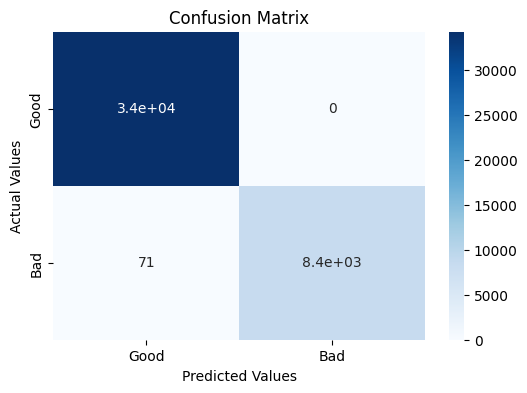

In [97]:
plt.figure(figsize=(6,4))
ax = sns.heatmap(cnf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['Good', 'Bad'])
ax.yaxis.set_ticklabels(['Good', 'Bad'])
plt.show()